# ANALISIS DE DATOS DE IMÁGENES .fits

Este notebook está dedicado a dejar registro y explicaciones de qué análisis estoy haciendo (y para qué) de las imágenes .fits del Skipper CCD.

Todas las imágenes usadas son de mediciones con Skipper CCD a una temperatura de 123 K.

Todos los análisis están hechos en profundidad para el OHDU 0 o primary. Los restantes dan MUY distintos.

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import skimage.measure

from analyfits import misc
from analyfits import datafits
from analyfits.manipufits import ManipulateFits

Defino 3 funciones: 

###### fits_finder(directorio, extension):
    Busca dentro de un directorio y todos sus subdirectorios las imágenes que cumplan los requisitos que impone la función: Estos son la extensión (por defecto .fits) y que no pesen más de 500kB (hardcodeado porque dentro de algún subdirectorio hay imágenes que pesan 100mB o similar que no me interesa estudiar)
    
###### ADU2e(src_path, alpha, beta, ohdu, save):
    Dado el directorio donde se encuentra la imagen .fits (src_path), abre la imagen, la transforma de unidades ADUs a unidades de electrón utilizando la calibración (con alpha y beta, que tienen un valor por defecto PERO QUE HAY QUE CHEQUEARLO PORQUE NO COINCIDEN CON LA TESIS DE KEVIN ANDERSON) y returnean un array de numpy con los datos de la nueva imagen transformada y la sin transformar. Además, si hay datos con valores negativos los hace 0.
    Si el parámetro save se pone en True (por defecto es False), además de returnear el array de numpy guarda una nueva imagen .fits con las nuevas unidades en el mismo directorio y con el sufijo en el nombre "electron_units.fits"
    
###### single_fits2double_fits(src_path, tgt_path, threshold, ohdu, save):
    Dado el directorio donde se encuentra la imagen .fits (src_path), usa la función ADU2e() para abrir la imagen y transformarla a unidades de electrones. Una vez que la imagen está transformada, usando el parámetro threshold (= 1 por defecto), genera a partir del array de numpy original 2 arrays de numpy,1 con los datos que cumplen que son menores o iguales que el threshold y otro con los datos que cumple que son mayores que el threshold. Ambos arrays son returneados al final. Si el parámetro save=True, entonces además guarda dos .fits nuevos en el directorio dado tgt_path (por defecto el actual) y les agrega en el nombre el sufijo minor/major.fits. 



Hardcodeo el directorio donde están todas las imágenes, por comodidad.
Además uso la función fits_finder() para meter en una lista todos los directorios dentro de T123K que tienen imágenes .fits que no superen los 500kB. Teniendo los directorios en una lista, es fácil llamarlos a todos para trabajar sobre las imágenes individualmente o sobre todas ellas al mismo tiempo.

In [2]:
DIR = "/home/igna/Escritorio/Tesis2021/Archivos/T123K_B"
os.chdir(DIR)
fits_imgs_list = misc.fits_finder(DIR)

Solo para testear que todo anda, agarro un directorio al azar de la lista de directorios y le aplico la función ADU2e. Grafico tanto la imagen en ADU's como la imagen en unidades de electron. 

Matplotlib normaliza automáticamente las imágenes, asi que por más que los valores de los array sean bien distintos, los colores que va a usar para ambos son los mismos.

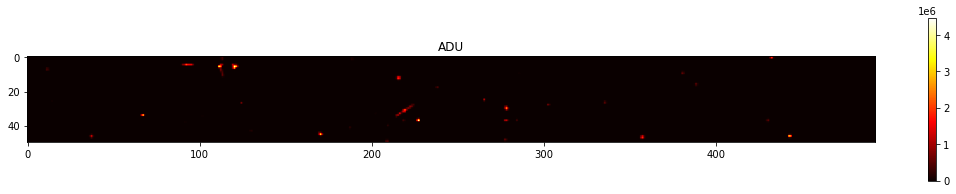

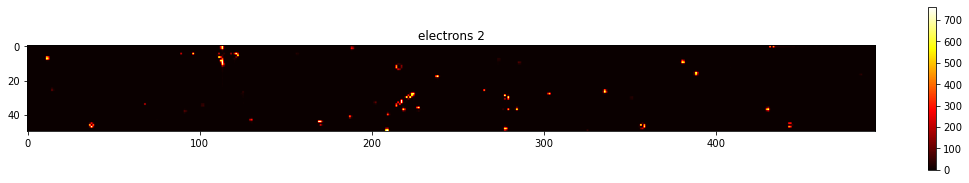

In [3]:
src_path = random.choice(fits_imgs_list)

fits_image = ManipulateFits()
e = ManipulateFits().ADU2e(src_path)
adu = ManipulateFits().ADU2e(src_path, ADU=True)

plt.figure(figsize=(19, 3))
plt.title("ADU")
plt.imshow(adu, cmap="hot")
plt.colorbar()
plt.figure(figsize=(19, 3))
plt.title("electrons 2")
plt.imshow(e, cmap="hot")
plt.colorbar();

Ahora pruebo la función que divide ambas imágenes según un dado threshold. Nótese que acá matplotlib de nuevo normaliza las imágenes. Si yo le seteara a imshow(vmin=0, vmax=15000) a ambas imágenes de forma que ambas tuvieran exactamente la misma normalización, en la primera imagen no se vería nada, pero la segun sí.

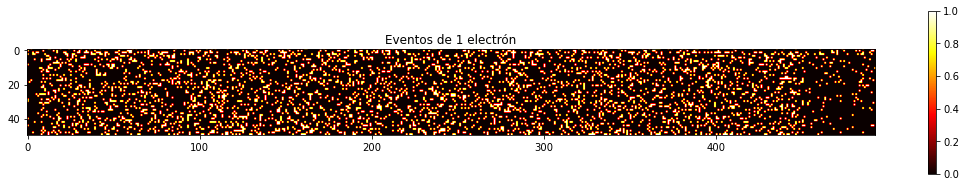

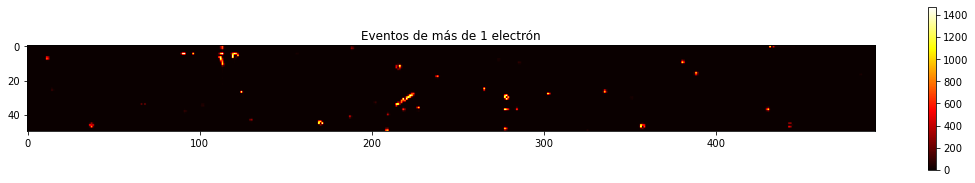

In [4]:
fits_image.set_ohdu(ohdu=0)
minor, major = fits_image.single_fits2double_fits(src_path)
plt.figure(figsize=(19, 3))
plt.title("Eventos de 1 electrón")
plt.imshow(minor, cmap="hot",
          #vmin=0, vmax=15000
          )
plt.colorbar()
plt.figure(figsize=(19, 3))
plt.title("Eventos de más de 1 electrón")
plt.imshow(major, cmap="hot",
          #vmin=0, vmax=15000
          )
plt.colorbar();

Acá hay una seguidilla de 20 imágenes de eventos de más de 1 electrón

In [5]:
%matplotlib inline
# ============================================
# VERSIÓN PARA NOTEBOOK
#from IPython import display
#fig = plt.figure(figsize=(19, 3))
#for i, elem in enumerate(fits_imgs_list[:30]):
#    minor = single_fits2double_fits(elem, ohdu=0)[0]
#    plt.imshow(minor, cmap="hot",
              #vmin=0, vmax=.5
#              )
#    plt.gcf().set_size_inches(19, 3)
#    display.display(plt.gcf())
#    display.clear_output(wait=True)
#    plt.pause(.01)
# ============================================
# VERSION ORIGINAL PARA IDE
#image = None
#fig = plt.figure(figsize=(19, 3))
#for i, elem in enumerate(fits_imgs_list):
#    minor = single_fits2double_fits(elem)[1]
#    if image is None:
#        image = plt.imshow(minor, cmap="hot")
#    else:
#        image.set_data(minor)
#    plt.title("Imagen N %i" % i)
#    plt.pause(.01)
#    if i == 20:
#        break

Voy a tomar todas las imágenes .fits que tengo, las voy a procesar, voy a quedarme con las de eventos de 1 electrón, las sumo todas y hallo el promedio. Ese promedio lo grafico. El resultado: Una imagen coloreada con los valores de probabilidad de obtener de un evento de 1 electrón por pixel en el CCD.
Entonces, las partes más brillantes corresponden a mayor probabilidad de tener un evento por pixel. Lo importante a notar es que hay dos costados de la imagen que son oscuros. Entonces, se tinen dos regiones oscuras de baja probabilidad y una región brillante central: El pre-scan y el over-scan.

Por otro lado, en la primera fila de píxeles del CCD, en la región del pre-scan, se ve un único pixel muy iluminado. Por algún motivo ese pixel tiene 83% de probabilidades.

100.00%

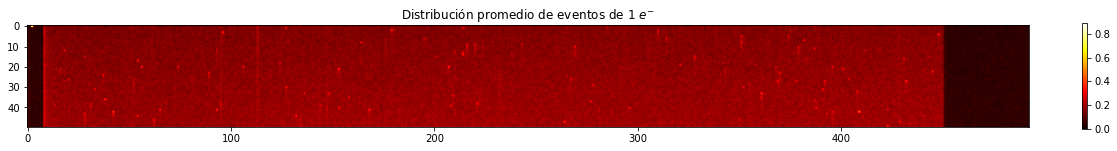

In [6]:
image_prom = 0
N = len(fits_imgs_list)
for i, elem in enumerate(fits_imgs_list):
    fits_image = ManipulateFits()
    fits_image.set_ohdu(ohdu=0)
    image_prom += fits_image.single_fits2double_fits(elem)[0]/N
    print("\r%.2f%%" % (100*i/(len(fits_imgs_list)-1)), end = "")

plt.figure(figsize=(19, 3))

plt.imshow(image_prom, cmap="hot")
plt.colorbar(fraction=0.005)
plt.title("Distribución promedio de eventos de 1 $e^{-}$");

In [7]:
from analyfits.manipufits import ManipulateFits

mean_img_list = []
for ohdu in range(4):
    image_prom = 0
    for i, elem in enumerate(fits_imgs_list):
        # src_path = DIR + elem
        image = ManipulateFits()
        image.set_ohdu(ohdu)
        image_prom += image.single_fits2double_fits(elem)[0]/N
        print("\r%.2f%%" % (100*i/(len(fits_imgs_list)-1)), end = "")
    mean_img_list.append(image_prom)
    print("\nfinished")

100.00%
finished
100.00%
finished
100.00%
finished
100.00%
finished


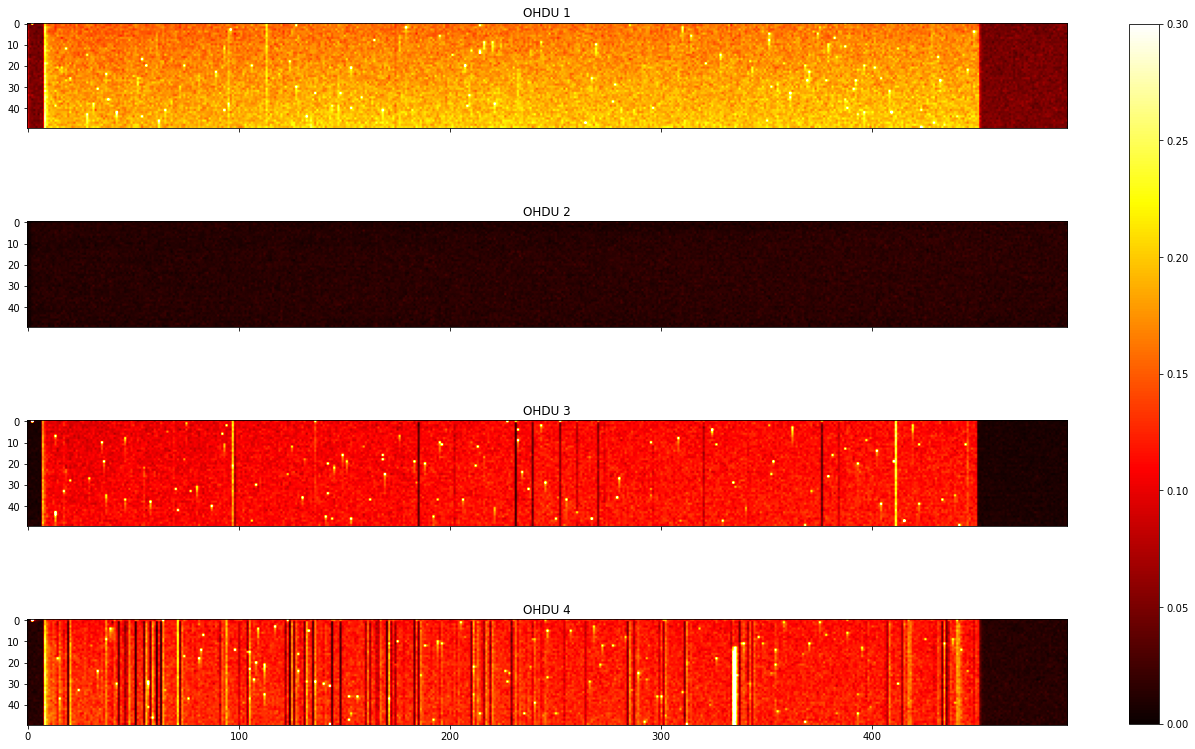

In [8]:
fig, axs = plt.subplots(4, 1, figsize=(17, 12), sharex=True)
for ohdu, image in enumerate(mean_img_list):
    im = axs[ohdu].imshow(image, cmap="hot", vmin=0, vmax=.3)
    axs[ohdu].title.set_text(f"OHDU {ohdu+1}")
#plt.figure(figsize=(19, 3), tight_layout=True)

plt.subplots_adjust(left=0.05,
                    bottom=0.05, 
                    right=0.9, 
                    top=0.95, 
                    wspace=0.1, 
                    hspace=0.1)
cbar_ax = fig.add_axes([0.95, 0.095, 0.025, 0.81])
fig.colorbar(im, cax=cbar_ax)
#plt.savefig("/home/igna/Escritorio/Tesis2021/imagenes_tesis/1ePromedio.pdf")
#plt.title("Distribución promedio de eventos de 1 $e^{-}$");
plt.show()

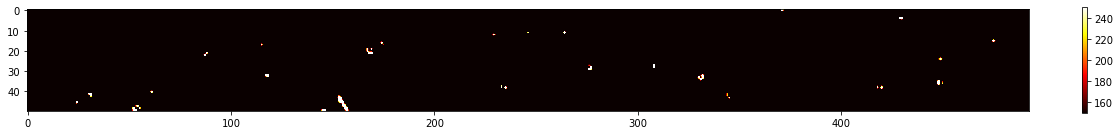

In [9]:
fits_image = ManipulateFits()
imagen = fits_image.single_fits2double_fits(fits_imgs_list[350])[1]
plt.figure(figsize=(19, 3))

plt.imshow(imagen, cmap="hot", vmin=150, vmax=250)
plt.colorbar(fraction=0.005);

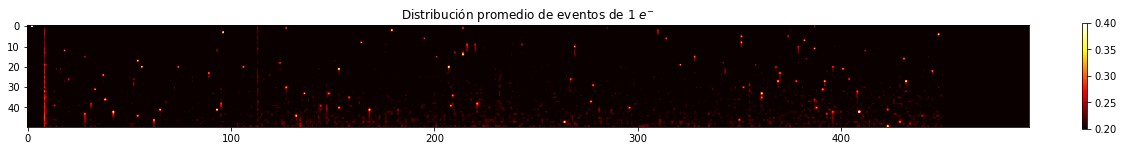

In [10]:
plt.figure(figsize=(19, 3))
image_prom = mean_img_list[0]
plt.imshow(image_prom, cmap="hot", vmin=0.2, vmax=.4)
plt.colorbar(fraction=0.005)
plt.title("Distribución promedio de eventos de 1 $e^{-}$");

Ahora quisiera ver más o menos si la probabilidad está distribuida uniformemente a lo largo del CCD. Para eso voy a tomar, de las 50 filas del detector, las filas 0, 10, 20, 30, 40 y 49 y voy a graficar las probabilidades en función de los 493 píxeles de cada fila. El resultado es el perfil de probabilidades. 

Se puede ver el pixel rebelde que tiene probabilidad del 83%, además de algunos picos aislados de alta probabildad.

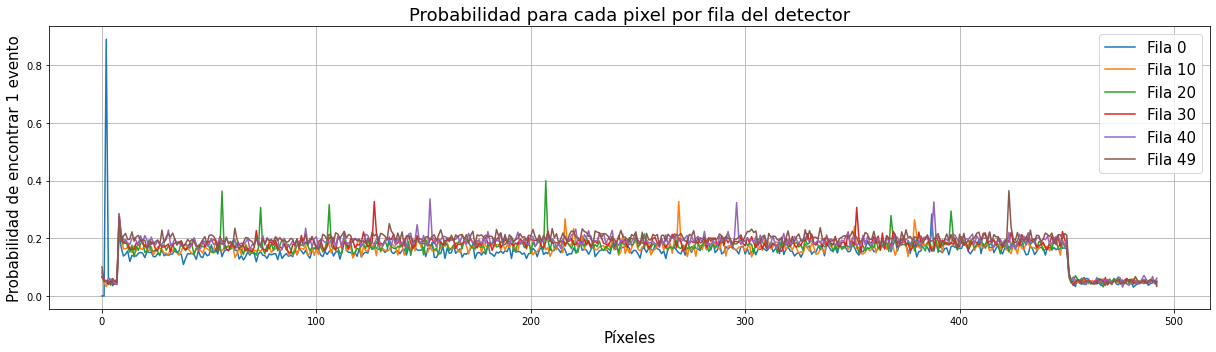

In [11]:
# =============================================================================
# VOY A GRAFICAR SIMPLEMENTE LOS VALORES RESPECTO A CADA PIXEL PARA VER
# SI SON MÁS O MENOS UNIFORMES (EN LAS FILAS)
# =============================================================================
filas = [0, 10, 20, 30, 40, 49]
plt.figure(figsize=(17, 5), tight_layout=True)
plt.grid()

for i in filas:
    plt.plot(image_prom[i, :],
             label="Fila %i" % i)
plt.title("Probabilidad para cada pixel por fila del detector", fontsize=18)
plt.xlabel("Píxeles", fontsize=15)
plt.ylabel("Probabilidad de encontrar 1 evento", fontsize=15)
plt.legend(fontsize=15);
# plt.savefig("Profile_prob_per_row.pdf")

Sumo todas las contribuciones y veo el resultado: Es decir, tomo las 50 filas, sumo columna a columna y grafico el perfil nuevamente en las 493 columnas que hay

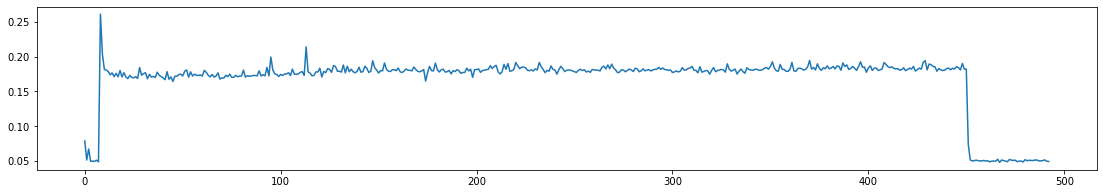

In [12]:
N_filas = image_prom[:, 0].size
suma = 0
for i in range(N_filas):
    suma += image_prom[i,:]/N_filas

plt.figure(figsize=(19,3))
plt.plot(suma);

Repito el análisis para las columnas. Tomo algunas columnas al azar, una columna de la primera región oscura (5), la primera columa de la región brillante (8)(que por alguna razón, es la zona más brillante), una columna cualquiera de la región brillante (300) y una columna de la segunda región oscura (492).

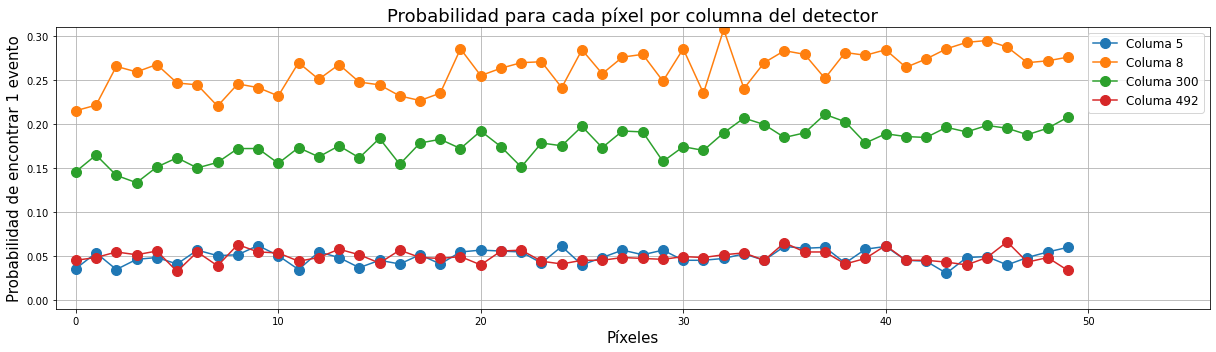

In [13]:
# =============================================================================
# VOY A GRAFICAR SIMPLEMENTE LOS VALORES DE PROBABILIDAD RESPECTO A CADA PIXEL
# PERO ESTA VEZ EN LAS COLUMNAS
# =============================================================================
# columnas = [0, 5, 8, 50, 100, 350, 470, 492]
columnas = [5, 8, 300, 492]
plt.figure(figsize=(17, 5), tight_layout=True)
for i in columnas:
    plt.plot(image_prom[:, i],
             "o-",
             markersize=10,
             label="Columa %i" % i)
plt.axis([-1, 56, -.01, .31])
plt.title("Probabilidad para cada píxel por columna del detector", fontsize=18)
plt.ylabel("Probabilidad de encontrar 1 evento", fontsize=15)
plt.xlabel("Píxeles", fontsize=15)
plt.legend(fontsize=12)
plt.grid()
# plt.savefig("Profile_prob_per_column.png")

Se ve como las probabilidades de las regiones del pre-scan y el overscan son similares, la probabilidad de la región activa es más alta y la probabilidad de la columna 8 es más alta que el resto. ¿Por qué?


Como prestando mucha atención se ve que, por algún motivo, la parte inferior del CCD tiene mayor probabilidad que la parte superior, hice el siguiente gráfico (parecido al anterior de la imagen del CCD, pero partido en las regiones) y lo saturé para que se note bien el gradiente en los colores.

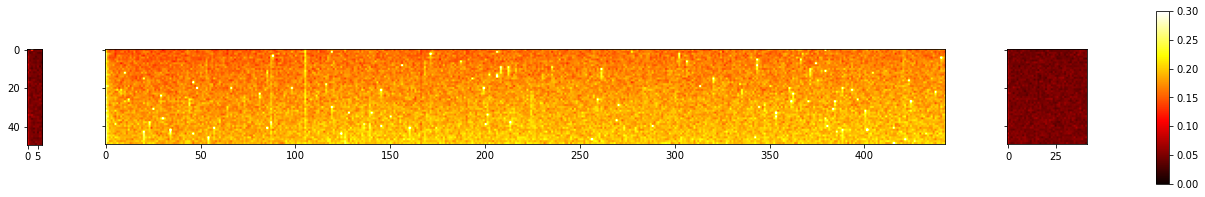

In [14]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(19, 3),
                        gridspec_kw={'width_ratios': [.11, 6, .57],
                                     'height_ratios': [1]})
idx = [0, 8, 451, 493]
for i, ax in enumerate(axs.flat):
    im = ax.imshow(image_prom[:, idx[i]:idx[i+1]], cmap="hot",
                   vmin=0, vmax=.3)

cbar_ax = fig.add_axes([.95, 0.1, 0.01, 0.8])
fig.colorbar(im, cax=cbar_ax);
# plt.savefig("Image_prom_sat.png")

Se nota mucho como la parte inferior "brilla" más que la superior. Para ver esto en detalle hice histogramas de la probabilidad por píxel de tener un evento de 1 electrón, para las filas 0, 10, 20, 30, 40 y 49. El resultado es un histograma de probabilidades o una "distribución de probabilidad de probabilidades" (un kilombo).

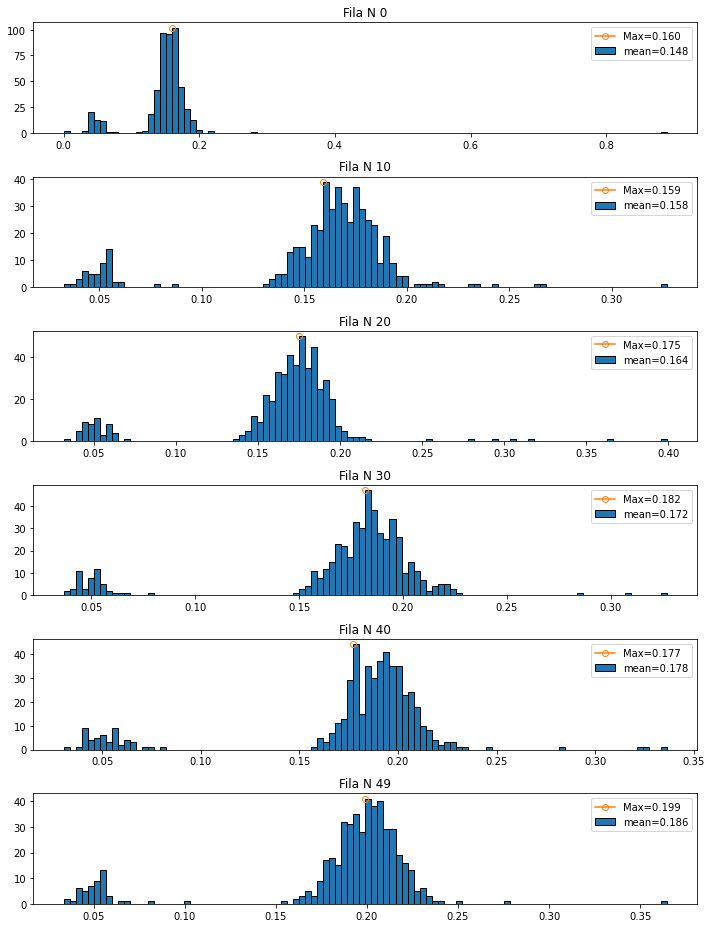

In [15]:
fig, axs = plt.subplots(6, 1, figsize=(10, 13), sharex=False, tight_layout=True)
filas = [0, 10, 20, 30, 40, 49]
for i, ax in enumerate(axs):
    # calculo el valor medio (pero como tiene mas de un pico no es el valor
    # más probable
    valor_medio = np.mean(image_prom[filas[i], :])
    ax.set_title("Fila N %i" % filas[i])
    hist = ax.hist(image_prom[filas[i], :],
                   bins=100,
                   label="mean=%.3f" % valor_medio,
                   edgecolor="black")
    # Ploteo donde está el valor más probable
    counts = hist[0]
    bins = hist[1]
    max_counts_idx = np.where(counts == max(counts))
    ax.plot(bins[max_counts_idx[0]], counts[max_counts_idx[0]],
            marker="o",
            label="Max=%.3f" % bins[max_counts_idx][0],
            fillstyle="none")
    xticks = ax.get_xticks()
    ax.legend()
# plt.savefig("ProbDensHist_xaxis_each10rows.pdf")

Estos histogramas están buenos porque muestran que sí "el valor medio de la probabilidad" se corre para la derecha a medida que bajas en las filas del detector, de la misma manera que lo hace el valor más probable (que lo señalé como "Max"). Además, se ve que la distribución tiene más de un pico.

Puedo el histograma del promedio de las 50 filas también

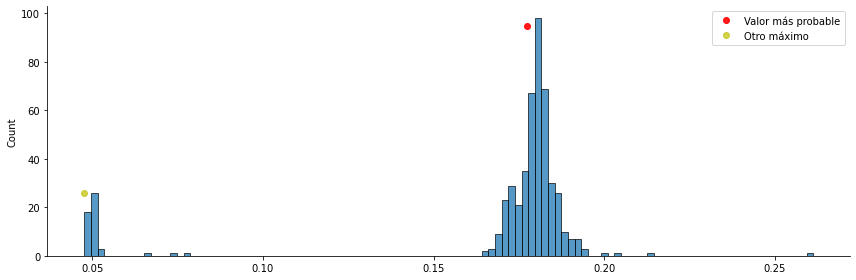

In [16]:
import seaborn as sns
sns.displot(np.mean(image_prom, axis=0), height=4, aspect=3)
plt.plot(0.17735, 95, "ro", alpha=.9, label="Valor más probable")
plt.plot(0.04753, 26, "yo", alpha=.7, label="Otro máximo")
plt.legend();

Y a dedo busqué el máximo (el valor medio te lo debo), que está aprox en 1.177.

Viendo que en efecto el valor medio cambia a medida que bajo en las filas, calculo el valor medio para todas las 50 filas y lo grafico en función del número de filas. 

Además, repito para cada region individualmente para ver también la diferencia entre valores medios de cada región.

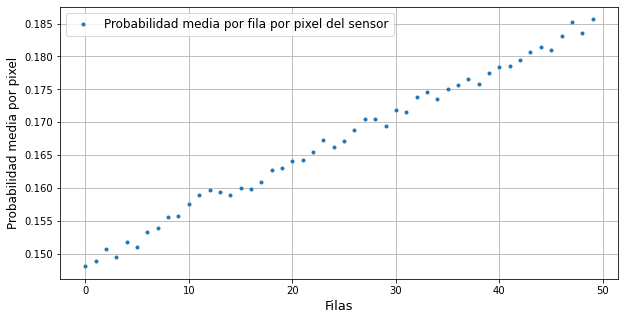

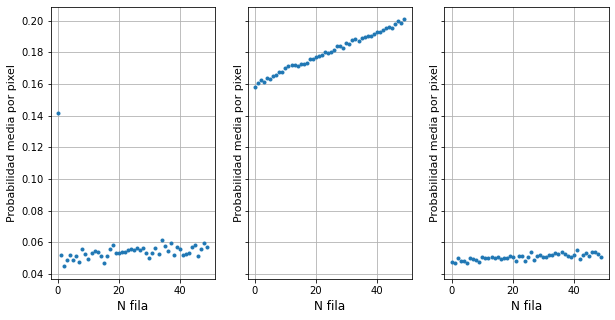

In [17]:
image_prom = mean_img_list[0]

plt.figure(figsize=(10,5))
plt.plot(np.mean(image_prom, axis=1), '.',
         label="Probabilidad media por fila por pixel del sensor")
plt.grid()
plt.xlabel("Filas", fontsize=13)
plt.ylabel("Probabilidad media por pixel", fontsize=12)
plt.legend(fontsize=12)
# plt.savefig("Mean_prob_per_row.png")
# Y ahora lo mismo pero dividiendo en regiones
fig, axs = plt.subplots(1, 3, figsize=(10, 5), sharey=True)
idx = [0, 8, 451, 493]
for i, ax in enumerate(axs.flat):
    ax.plot(np.mean(image_prom[:, idx[i]:idx[i+1]], axis=1), '.')
    ax.set_ylabel("Probabilidad media por pixel", fontsize=11)
    ax.set_xlabel("N fila", fontsize=12)
    ax.grid()
# plt.savefig("Mean_prob_per_row_per_zone.png")

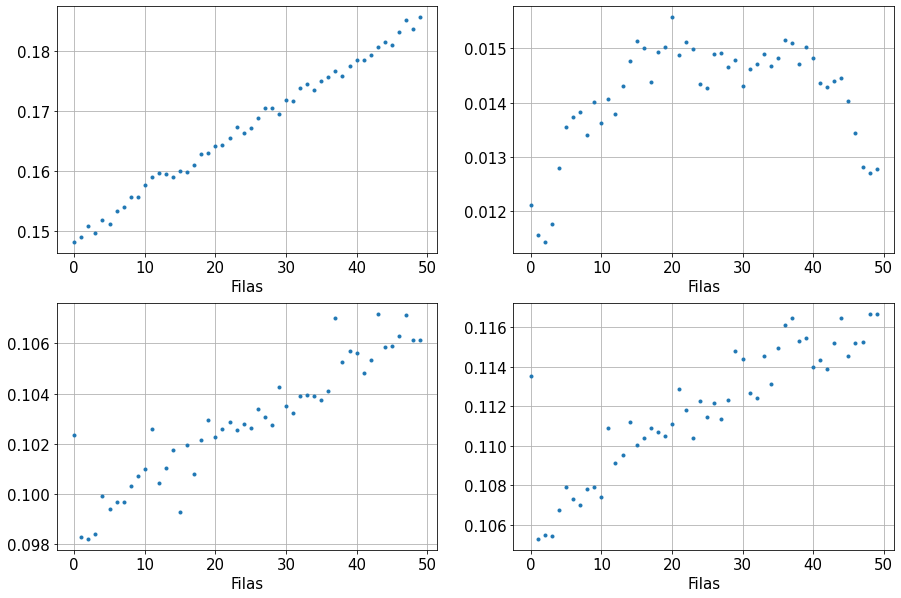

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
img = 0
for i in range(2):
    for j in range(2):
        axs[i, j].plot(np.mean(mean_img_list[img], axis=1),'.')
        axs[i, j].grid()
        axs[i, j].set_xlabel("Filas", fontsize=15)
        axs[i, j].tick_params(axis='both',labelsize=15)
        img += 1

#plt.savefig("/home/igna/Escritorio/Tesis2021/imagenes_tesis/gradiente_prob.pdf")

Resulta que este efecto puede ser producido por la forma en la que se leen los píxeles del sensor. Primero comienza colectándose la iformción de las filas superiores de forma secuencial. Esto provoca que las filas inferiores estén en promedio más tiempo expuestas hasta que son "medidas". Si bien el $\Delta t$ es pequeño, el resultado sigue siendo un efecto apreciable.

Queriendo repetir el análisis para las columnas, tomo algunas columnas y grafico los histogramas de sus probabilidades. No da ningún tipo de tendencia obvia.

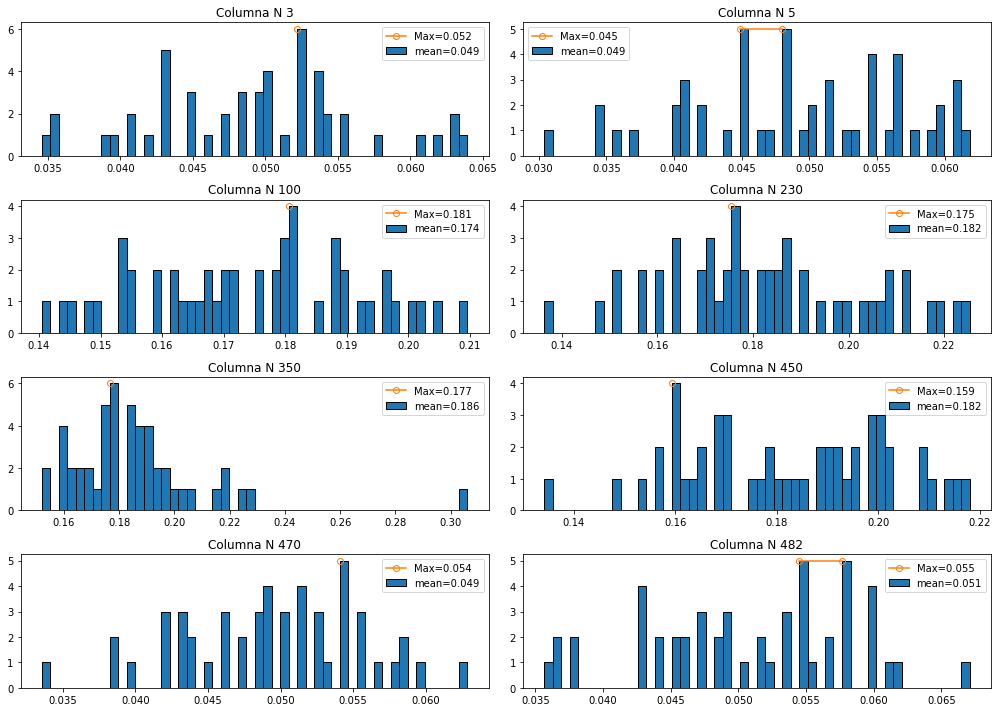

In [19]:
fig, axs = plt.subplots(4, 2, figsize=(14, 10),
                        sharex=False,
                        tight_layout=True)
# las columnas que voy a mirar
columnas = [3, 5, 100, 230, 350, 450, 470, 482]
i = 0
for Ax in axs:
    for ax in Ax:
        # calculo el valor medio (pero como tiene mas de un pico no es el valor
        # más probable
        valor_medio = np.mean(image_prom[:, columnas[i]])
        ax.set_title("Columna N %i" % columnas[i])
        hist = ax.hist(image_prom[:, columnas[i]],
                       bins=50,
                       label="mean=%.3f" % valor_medio,
                       edgecolor="black")
        # Ploteo donde está el valor más probable
        counts = hist[0]
        bins = hist[1]
        max_counts_idx = np.where(counts == max(counts))
        ax.plot(bins[max_counts_idx[0]], counts[max_counts_idx[0]],
                marker="o",
                label="Max=%.3f" % bins[max_counts_idx][0],
                fillstyle="none")
        xticks = ax.get_xticks()
        ax.legend()
        i += 1
# plt.savefig("ProbDensHist_xaxis_each10rows.pdf")


# Finalmente

Calculo los valores medios con su error, para la probabilidad por pixel de tener un evento de 1 electrón:

In [20]:
mean_prob = np.mean(image_prom)
std_prob = np.std(image_prom)

mean_1darkzone = np.mean(image_prom[:, 0:8])
std_1darkzone = np.std(image_prom[:, 0:8])

mean_brightzone = np.mean(image_prom[:, 8:451])
std_brightzone = np.std(image_prom[:, 8:451])

mean_2darkzone = np.mean(image_prom[:, 452:493])
std_2darkzone = np.std(image_prom[:, 452:493])
print("El valor medio de probabilidad de tener un evento de 1 electron por",
      "píxel, en todo el detector, es %.4f +/- %.4f." % (mean_prob, std_prob))

print("El valor medio de probabilidad de tener un evento de 1 electrón por",
      "píxel, en el pre-scan, es %.4f +/- %.4f" % (mean_1darkzone,
                                                   std_1darkzone))

print("El valor medio de probabilidad de tener un evento de 1 electrón por",
      "píxel, en la región activa, es %.4f +/- %.4f" % (mean_brightzone,
                                                        std_brightzone))

print("El valor medio de probabilidad de tener un evento de 1 electrón por",
      "píxel, en el over-scan, es %.4f +/- %.4f" % (mean_2darkzone,
                                                    std_2darkzone))

El valor medio de probabilidad de tener un evento de 1 electron por píxel, en todo el detector, es 0.1671 +/- 0.0442.
El valor medio de probabilidad de tener un evento de 1 electrón por píxel, en el pre-scan, es 0.0555 +/- 0.0439
El valor medio de probabilidad de tener un evento de 1 electrón por píxel, en la región activa, es 0.1802 +/- 0.0213
El valor medio de probabilidad de tener un evento de 1 electrón por píxel, en el over-scan, es 0.0501 +/- 0.0073


$$P_{global} = 0.1671 \pm 0.044$$
$$P_{PS} = 0.0555 \pm 0.0439$$
$$P_{RA} = 0.1802 \pm 0.0213$$
$$P_{OS} = 0.0501 \pm 0.0073$$

# Análisis del número de píxeles que ocupan los clusters

Ahora quiero ver cuántos píxeles del CCD ocupan los clusters. Primero voy a ver simplemente cuántos pixeles hay ocupados por eventos de 2 o más electrones (que es lo más fácil). Después voy a intentar ver si puedo extraer solamente lo de los clusters.

Teniendo el número de píxeles ocupados por eventos de 2 o más electrones, vuelvo a calcular la probabilidad corrigiendo con este valor.

In [21]:
# elijo una imagen al azar
src_path = random.choice(fits_imgs_list)
# me genero las dos: Una con eventos de 1 electrón y otra con el resto
fits_image = ManipulateFits()
minor, major = fits_image.single_fits2double_fits(src_path)
# printeo el número total de elementos 
print("El número total de elementos (o equivalentemente, el número de pixeles del sensor) es %i" % major.size)

El número total de elementos (o equivalentemente, el número de pixeles del sensor) es 24650


Entonces, como el número total de píxeles es 24650, para la imagen que tiene solo los eventos de un electrón, la suma de los píxeles ocupados por 1 e y los píxeles vacíos debe ser 24650 (trivialmente, pero lo chequeo por las dudas). Idem para la imagen de los eventos de 2 o más electrones

In [22]:
# la cantidad de píxeles con un eletrón + la cantidad de píxeles con 0 = 24650
minor[minor == 1].size + minor[minor == 0].size == 24650

True

In [23]:
# la cantidad de píxeles con 0 + la cantidad de píxeles con 2 o más = 24650
major[major == 0].size + major[major > 1].size == 24650

True

Bueno, todo tiene sentido por ahora.

Ahora sólo quiero ver, para esta imagen elegida al azar, cuánto es la proporción de píxeles con eventos vs no eventos. Tanto para la minor como para la major. Después voy a ver valores promedio

In [24]:
# Proporcion de píxeles ocupados por un electrón respecto del número total de píxeles del sensor
proporcion = minor[minor == 1].size/minor.size
print("Hay un %.4f%% de píxeles ocupados por eventos de un electrón" % (proporcion * 100) )

Hay un 16.5639% de píxeles ocupados por eventos de un electrón


In [25]:
# Proporcion de píxeles ocupados por eventos de 2 o más electrones respecto del número total de píxeles del sensor
proporcion = major[major > 1].size/major.size
print("Hay un %.4f%% de píxeles ocupados por eventos de 2 o más electrones" % (proporcion * 100) )

Hay un 3.2454% de píxeles ocupados por eventos de 2 o más electrones


A ver los promedios:

Acá se puede elegir que OHDU usar, va a tomar todas las imágenes y va a calcular la proporción de eventos de 1 electrón por imagen y la proporción de 2 o más eventos por imagen. Luego los promedia para tener el resultado final

In [26]:
prop_1e = []
prop_2omas_e = []
N_2omas_e = []
for i, imagen in enumerate(fits_imgs_list):
    fits_image = ManipulateFits()
    minor, major = fits_image.single_fits2double_fits(imagen)
    prop_1e.append(minor[minor == 1].size/minor.size)
    prop_2omas_e.append(major[major > 1].size/major.size)
    N_2omas_e.append(major[major > 1].size)
    print(f"\r{(i+1)*100/len(fits_imgs_list):.2f}%", end="")
    
prop_prom_1e = np.mean(prop_1e)
prop_prom_2omas_e = np.mean(prop_2omas_e)
print("\nLa proporción promedio de eventos de 1 electrón es de %.2f%%" % (prop_prom_1e*100))
print("La proporción promedio de eventos de 2 o más electrones es de %.2f%%" % (prop_prom_2omas_e*100))
    

100.00%
La proporción promedio de eventos de 1 electrón es de 16.70%
La proporción promedio de eventos de 2 o más electrones es de 3.69%


Ya tengo la proporción promedio de eventos tanto de 1 electrón como de 2 o más electrones. La segunda es de aprox 3.71%, pero si miro la proporción en todas las imágenes veo que hay unos saltos que no se me ocurre a qué se pueden deber.

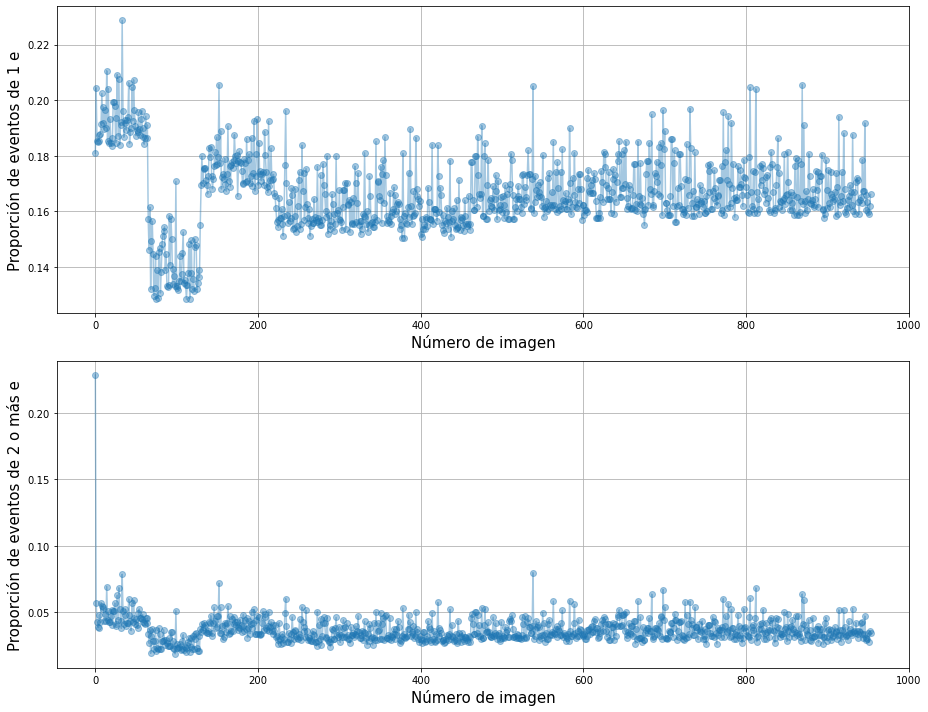

In [27]:
fig, axs = plt.subplots(2, 1, figsize=(13, 10), tight_layout=True)
axs[0].plot(prop_1e, 'o-', alpha=.4)
axs[0].set_xlabel("Número de imagen", fontsize=15)
axs[0].set_ylabel("Proporción de eventos de 1 e", fontsize=15)
axs[0].grid()
axs[1].plot(prop_2omas_e, 'o-', alpha=.4)
axs[1].set_xlabel("Número de imagen", fontsize=15)
axs[1].set_ylabel("Proporción de eventos de 2 o más e", fontsize=15)
axs[1].grid()

En definitiva, debería usar las primeras 200-250 imágenes que tienen estos saltos en la proporción de eventos o no?

###### Más allá de eso:
    # Ya tengo la propabilidad promedio por píxel de que tener un evento de 1 electrón, para 4 casos:
        1) Caso global de todo el sensor,
        2) Pre-scan,
        3) Región activa,
        4) Over-scan,
    # Ya tengo la proporción promedio de eventos de 2 o más electrones (global de todo el senor ¿Vale la pena la de cada región?)

Asi que ahora voy a corregir la probabilidad **global** usando la proporción global (más precisamente, el número promedio de eventos de 2 o más electrones)

In [29]:
# Esta es una lista con las cantidades de eventos de 2 o más electrones
N_2omas_e = np.array(N_2omas_e)
print("Valor medio: %.2f eventos" % N_2omas_e.mean())
print("Desviación estandar: %.2f eventos" % N_2omas_e.std())

Valor medio: 910.57 eventos
Desviación estandar: 253.76 eventos


O sea, lo que tengo que hacer es tomar los 24650 píxeles totales del detector y restarles 914 píxeles. Usando la ```image_prom```, sumo todos sus elementos y en vez de dividir por 24650, divido por 24650-914 

In [30]:
# Corrijo el número de píxeles
N_pixeles_corregido = image_prom.size - 914
# Calculo la probabilidad global
Prob_global_corregida = np.sum(image_prom)/N_pixeles_corregido
print("La probabilidad global corregida es %.3f" % Prob_global_corregida)

La probabilidad global corregida es 0.174


También podría directamente hacer una nueva imagen promedio teniendo en cuenta para cada imagen la cantidad de píxeles que consumen los eventos de 2 o más electrones, esto sería hacer:
###### 
    1) Tomo una imagen y divido cada elemento de esa imágen por el número de píxeles sin eventos de 2 o más electrones.
    2) Toma la siguiente imagen, repito el paso anterior, y se la sumo a la imagen anterior.
    3) Repito hasta agotar las imágenes.
    4) Una vez que tengo una imagen suma de eventos de un electrón dividido por el número de píxeles sin eventos de 2 o más electrones, divido cada elemento de esa imagen sumada por el número total de imágenes que usé (para promediar sobre el número de imágenes).
    5) Ahora tengo una imagen que no significa nada, pero si sumo todos sus elementos, esa suma será la probabilidad promedio corregida de tener un evento de 1 electrón por pixel del sensor.

### Escrito otra notación:

Tomo $Im_{i}$ como las matrices en $R^{n\times m}$ que representan a las imágenes con eventos de $1$ electrón, y $Mm_{i}$ como las matrices de $R^{n \times m}$ que representan a las imágenes con eventos de $2$ o más electrones. Donde $n = 50$ (filas) y $m = 493$ (columnas de la región activa). Defino una función $C$ tal que $C(Im_{i}|n)$ es el número de píxeles ocupados por eventos de $n$ electrones de la imagen $i$-ésima. De la misma forma, $C(Mm_{i}|\geq 2)$ es el número de píxeles ocupados por eventos de $2$ o más electrones (esto lo implemento con ```numpy``` de la siguiente manera: ```imagen[imagen == 1].size``` y ```imagen[image >= 2].size``` respectivamente).

El proceso que describo arriba puede resumirse con la expresión
$$ 
    A = \frac{1}{N}\sum\limits_{i=1}^{N} \frac{Im_{i}}{L - C(Mm_{i}|\geq 2)}
$$

donde $L$ es el número total de píxeles de la región activa de una imagen ($22150$). El denominador es un escalar, o sea que estoy diviendo cada elemento de la matriz $Im_{i}$ por ese escalar y a su vez sumando sobre todas las imágenes. $N = 924$, el número total de imágenes. $A\ \in\ R^{n\times m}$ y no tiene interpretación *física*. 

Sin embargo, la suma de todos sus elementos termina siendo la proporción de píxeles ocupados por eventos de un electrón, descontando el sesgo de los píxeles ocupados por eventos de 2 o más electrones. Dicha proporción es la probabilidad de tener un electrón espurio por pixel (casos favorables / casos totales).

Entonces, la probabilidad sería

$$ P = \sum\limits_{i,j}^{n, m} A_{ij} $$

Implemento este proceso en la siguiente celda

In [31]:
image_prom_corr = 0
N = len(fits_imgs_list)

for i, img in enumerate(fits_imgs_list):
    fits_image = ManipulateFits()
    minor, major = fits_image.single_fits2double_fits(img)
    # redimensiono las imágenes para solo mirar la región activa
    minor = minor[:,8:451]
    major = major[:,8:451]
    # tomo el número total píxeles de la región activa
    total_size = major.size
    # tomo el número total píxeles ocupados por eventos de 2 o más electrones
    N_ev_2omas = major[major > 1].size
    # sumo las imágenes de 1 electrón ya divididas por el número de pixeles libres (sin eventos 2 o más e-)
    image_prom_corr += minor/(total_size - N_ev_2omas)
    # printeo el progreso
    print("\r%.2f%%" % (100*i/(len(fits_imgs_list)-1)), end = "")

# ahora divido el resultado anterior por el número de imágenes
image_prom_corr /= N
# finalmente, sumo todos los elementos (eso es el promedio)
prob_corr_global = np.sum(image_prom_corr)
print("\nLa probabilidad global resulta %.5f%%" % (prob_corr_global*100))
prob = prob_corr_global

100.00%
La probabilidad global resulta 18.78325%


**OBS:** Esta probabilidad $P = 0.1834654$ es la probabilidad de que en un pixel haya solamente un electrón espúrio.

Notar que estoy dividiendo el número total de eventos de 1e, sobre el número total de píxeles del sensor (región activa) menos la cantidad de píxeles ocupados por 2 o más electrones. En definitiva es dividir por el número de píxeles del sensor con 0 y con 1 electrones.

Esta implementación tiene algunos problemas:
- Es difícil calcular la incerteza del valor
- Es difícil ver el sesgo que añade dividir por N todos los píxeles, siendo que algunos píxeles en realidad no tiene el "aporte" de algunas imágenes, dado que estoy descontando eventos de 2 o más electrones. Es decir: Suponiendo que tengo 3 imágenes completas 1,2, y 3 y que el pixel $i$, en la imagen 1, tengo 1 electrón, en la imagen 2 tengo 0 electrones y en la imagen 3 tengo 50 electrones. El pixel $i$-ésimo de la tercera imagen en esta implementación, vale 0 y no aporta. Mientras que el píxel $i$-ésimo de la imagen 1 y 2 sí aportan. De forma que debería dividir por $N=2$ y no por $N=3$. En esta implementación estoy sesgando la medición al dividir siempre por $N$ fijo.

Una implementación más sencilla consta en considerar a todas las imágenes completas (pero solo mirando región activa) y contar la cantidad total (en todas las imágenes) de píxeles vacíos y píxeles con $1$ electrón. Dado que la variable aleatoria *número de electrones de ruido en un dado píxel* tiene distribución de Poisson, resulta que la probabilidad de tener $1$ electrón por píxel viene dada por

\begin{equation}
    p(\mu | k=1) = \mu e^{-\mu}
\end{equation}

mientras que la probabilidad de que en un dado píxel haya 0 electrones viene dada por 

\begin{equation}
    p(\mu | k=0) = e^{-\mu}
\end{equation}

de esta forma, la relación entre la probabilidad de tener $1$ electrón por píxel, sobre la probabilidad de tener $0$ electrones por píxel termina dando

\begin{equation}
    \frac{p(\mu|k=1)}{p(\mu|k=0)} = \frac{\mu e^{-\mu}}{e^{\mu}} = \mu
\end{equation}

Esto quiere decir que divido la cantidad total de píxeles ocupados por $1$ electron (en todas las imágenes) sobre la cantidad total de píxeles con 0 electrones, debería obtener el valor de $\mu$.

A su vez, esta implementación a demás de ser sencilla, tiene la cualidad de que es fácil calcular la incerteza del resultado, siempre suponiendo que la variable aleatoria tiene distribución de Poisson.
Entonces, sea $N$ el número total de píxeles ocupados por 1 electróny sea $M$ el número total de píxeles ocupados por 0 electrones (ambas tienen distribución de Poisson (por qué esto? PENSARLO)), defino $X$ como

\begin{equation}
    X = \frac{N}{M}
\end{equation}

Como $N$ y $M$ son Poissonianas, su error relativo es de la pinta $\frac{\sigma}{\mu}$, donde $\sigma = \sqrt{\mu}$, con lo cual el error relativo es $\frac{1}{\sqrt{\mu}}$. De esta forma, para $N$ es $1/\sqrt{N}$ y para $M$, $1/\sqrt{M}$. Para conocer la incerteza de $X$ hay que propagar las incertezas. La incerteza de $X$ la calculo con la siguiente expresión

\begin{equation}
    \left(\frac{\sigma(X)}{X}\right)^{2}
    = \left(\frac{\sigma(N)}{N}\right)^{2}
    + \left(\frac{\sigma(M)}{M}\right)^{2}
    \Longrightarrow
    \sigma(X) =
    X
    \left[
        \left(
            \frac{\sigma(N)}{N}
        \right)^{2}
        +
        \left(
            \frac{\sigma(M)}{M}
        \right)^{2}
    \right]^{1/2}
    = X
    \left[
        \frac{1}{N} + \frac{1}{M}
    \right]^{1/2}
\end{equation}

La implementación es sencilla y es como sigue

In [32]:
# ===========================================================================
N = len(fits_imgs_list)

# Guardo unas variables para ir acumulando la cantidad de píxeles con 0 y 1 e
ceros = 0
unos = 0

for i, img in enumerate(fits_imgs_list):
    # Uso las imágenes completas, solo en su región activa
    image = ManipulateFits().ADU2e(img)[:, 8:451]
    # Guardo la cantidad de ceros de cada imagen y los voy sumando
    ceros += image[image==0].size
    # Idem para los unos 
    unos += image[image==1].size
    
    # Progreso:
    print("\r%.2f%%" % (100*i/(len(fits_imgs_list)-1)), end = "")

# Calculo la probabilidad de que en un pixel caiga un electrón espurio
probabilidad = unos/ceros

# Calculo el error relativo
error = np.sqrt((1/np.sqrt(unos))**2 + (1/np.sqrt(ceros))**2)*(unos/ceros)

# Imprimo resultado
print("\nLa probabilidad resulta %.4f +/ %.4f" % (probabilidad, error))

100.00%
La probabilidad resulta 0.2311 +/ 0.0001


Notar que el primer método me da $p = 0.1834$ (no sé la incerteza) mientras que el segundo me da $p = 0.2245 \pm 0.0001$.
El primer método es equivalente a hacer
\begin{equation}
    \frac{p(\mu|k=1)}{p(\mu|k=1) + p(\mu|k=0)} = \frac{\mu}{\mu + 1} = R
\end{equation}

con $R = 0.1834$ y el segundo es hacer 
\begin{equation}
    \frac{p(\mu|k=1)}{p(\mu|k=0)} = \mu \approx 0.2245
\end{equation}

Si dela primera despejo $\mu$, resulta

\begin{equation}
    \mu = \frac{R}{1-R} \approx 0.2245
\end{equation}

y dan maravillosamente iguales. Voy a volver sobre esto más adelante.

# SEGUNDA PARTE
## Conteo de clusters y Montecarlo

### *Códigos cortesía de Santiago Perez*

Voy agarrar una imagen aleatoria de todas las que tengo y le voy a pasar la función ```get_cluster_size_and_intesity()``` para sacarle las propiedades que necesite, usando la función ```scipy```, ```ndi.label``` (usando el modelo de Santiago).

###### El procedimiento sería el siguiente
- Me genero el array de numpy que contiene la data de la imagen fits.
- Binarizo la imagen usando ```img2bw``` y la guardo en una nueva variable con sufijo ```_bw```. La imagen binarizada es un array de True's y False's. Se pierde la información de intesidades.
- Me armo mis "features labels" usando ```ndi.label``` dándole de comer a esa funcion la imagen binarizada a partir del threshold dado.
- El argumento ```structure``` de ```ndi.label``` define la forma en la que se conectan los features (en mi caso clusters): Se ve poniendo el centro del structure en cada pixel y ver qué valores caen dentro del struct. Esos pertenecerán al mismo clúster.
- Ahora sí uso ```get_cluster_info``` (que ya la modifiqué para que me de más propiedades) para obtener la información de los "features" que ndi encontró, en este caso los clusters. El input es el array de numpy con la información de la imagen y los labels que escupe ```ndi.labels```. El output es un diccionario con las siguientes keys: 
    - areas
    - centros
    - coordenadas
    - perimetro
    - energias
    - box
- ploteo la imagen y marco con círculos los clusters que reconoció



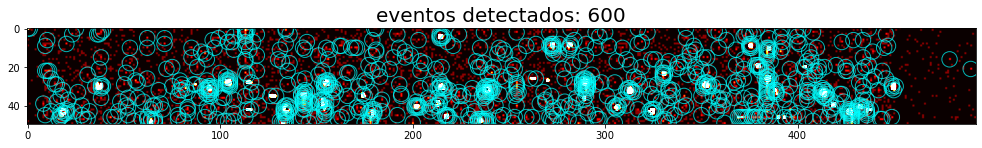

In [33]:
# ===========================================================================
from matplotlib.patches import Circle

# Tomo una imagen aleatoria del montón
image = random.choice(fits_imgs_list)

# Me genero el array de numpy con el ohdu de preferencia
# el elemento [0] corresponde a la imagen en unidades de e-
image_e = ManipulateFits().ADU2e(image)

# Binarizo la imagen
image_e_bw = misc.img2bw(image_e, low_th=2, upp_th=300)

# Genero las labels y también guardo el número de features
label_im, n_features = ndi.label(image_e_bw,
                                 structure=[[0, 1, 0],
                                            [1, 1, 1],
                                            [0, 1, 0]])

# Armo el diccionario con la información que me devuelve get_cluster_size_etc
dic = datafits.get_cluster_info(image_e, label_im)

# Me genero el layout del plot
fig, ax = plt.subplots(1, figsize=(17,2))

# Recorro en el diccionario a todos los valores de la key coordenadas y dibujo
# un círculo vacío en cada uno de los lugares donde el código vio un feature
# para poder saber cuáles son features y cuales no.
# NOTA: Las coordenadas son las de cada pixel del feature. Si hay un muón entre
# los features, entonces las coordenadas van a ser una tira de varias 
# coordenadas (longitud del muon)de forma que se van a plotear muchos circulitos
# siguiendo al muón. Lo mismo para todas las features
coordes = dic["coordenadas"]
for coord in coordes:
    for r in coord:
        r = list(r)
        r.reverse()
        label_im = skimage.measure.label(image_e_bw)
        circ = Circle(tuple(r), 4, alpha=.7, color="cyan", fill=False)
        ax.add_patch(circ)
# Ploteo la imagen
ax.imshow(image_e, cmap="hot", vmin=0, vmax=5);
plt.title("eventos detectados: %i" % n_features, fontsize=20);
#plt.savefig("/home/igna/Escritorio/imagen_asds.pdf")

Repito pero usando los centroides. La ventaja de los centroides es que no me ensucia tanto el plot. La desventaja es que me marca el centro incluso cuando son clusters largos.
También encierro a los clusters usando bbox, para saber qué está bien el código.

In [34]:
# =============================================================================
#fig, ax = plt.subplots(1, figsize=(17, 2), tight_layout=True)
#X = np.array(dic["centros"])
#for elem in X:
#    coord = (int(elem[1]),int(elem[0]))
#    circ = Circle(coord, 5, color="cyan", fill=False)
#    ax.add_patch(circ)

#Y = np.array(dic["box"])
#for elem in Y:
#    minr, minc, maxr, maxc = elem
#    bx = (minc-1/2, maxc-1/2, maxc-1/2, minc-1/2, minc-1/2)
#    by = (minr-1/2, minr-1/2, maxr-1/2, maxr-1/2, minr-1/2)
#    ax.plot(bx, by, '-b', linewidth=2.5)
    

#ax.imshow(image_e, cmap="hot", vmin=0, vmax=5);
#plt.savefig("/home/igna/Escritorio/imagen_bbox.pdf")

Efectivamente, estaban desfasados los boxes de los clusters. Tuve que meterles un offset de -1/2 a cada coordenada para que queden bien centrados. Los bordes del box coinciden con el último pixel que tiene un valor de electrones que cumple la condicion del umbral, en cada dirección

Ahora sin ver la imagen, repito recorriendo todas las imágenes y busco clusteres para un dado umbral. Luego guardo la información de cada cluster en una lista de diccionarios (donde cada diccionario contiene toda la informacion que me devuelve ```get_cluster_info```).

In [35]:
# =============================================================================
lista_dics = []
lista_n_features = []

for i, image in enumerate(fits_imgs_list):
    image_e = ManipulateFits().ADU2e(image)
    # Binarizo la imagen
    image_e_bw = misc.img2bw(image_e, low_th=2, upp_th=300)

    # Genero las labels y también guardo el número de features
    label_im, n_features = ndi.label(image_e_bw,
                                     structure=[[0, 1, 0],
                                                [1, 1, 1],
                                                [0, 1, 0]])

    # Armo el diccionario con información que devuelve get_cluster_size_etc
    dic = datafits.get_cluster_info(image_e, label_im)
    lista_dics.append(dic)
    lista_n_features.append(n_features)
    # Printeo el progreso del ciclo for
    print("\r%.2f%%" % (100*(i+1)/925), end = "")

103.14%

Una vez que tengo la lista con los diccionarios y los números de features (o de eventos), hago un histograma con las "energías", que en este caso, es un histograma de la cantidad de electrones de los clusters. También voy a hacer un histograma de la cantidad de features que encontró.

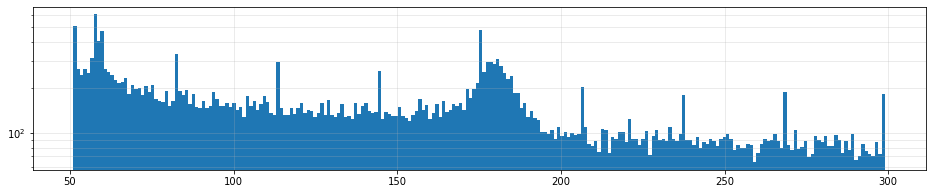

In [36]:
Energia_array = []
Perimetro_array = []
for dics in lista_dics:
    ener = np.array(dics["energias"])
    # elimino los cluster con más de 300 electrones
    ener = ener[ener < 300]
    # elimino los cluster con menos de 50 electornes
    ener = ener[ener > 50]

    Energia_array.append(ener)

# transformo todo a un array unico de numpy
Energia_array = np.concatenate(Energia_array)

# Grafico
plt.figure(figsize=(16, 3))
plt.hist(Energia_array, bins = 240);
plt.yscale("log")
plt.grid(which="both", alpha=.3)

Donde tengo el máximo en 180 (ojo que esto para el OHDU primario, o 0, o primero, pero para el resto no da ahí, da pasando los 220). Esto es un resultado esperado. Lo que no es esperado es el primer pico que aparece, entre 50 y 75.    

In [37]:
#nplist = np.array(lista_n_features)
#plt.figure(figsize=(9, 7))
#plt.hist(nplist,bins = 92);
#plt.grid(which="both", alpha=.3)

Un machete de como funciona y qué hace el structure de ndi_label

In [38]:
#from scipy.ndimage import label as sc_label

#a = np.array([[0, 1, 1, 0, 0, 0],
#              [0, 1, 1, 0, 1, 0],
#              [0, 0, 0, 1, 1, 1],
#              [0, 0, 0, 0, 1, 0]])
#s = [[1, 1, 1],
#     [1, 1, 1],
#     [1, 1, 1]]

#b = sc_label(a, s)

#fig, axs = plt.subplots(1,2)
#axs[0].imshow(a,cmap="Greys")
#axs[1].imshow(b[0], cmap="Greys")


In [39]:
#from skimage.measure import label as sk_label
#a = np.array([[0, 1, 1, 0, 0, 0],
#              [0, 1, 1, 0, 1, 0],
#              [0, 0, 0, 1, 1, 1],
#              [0, 0, 0, 0, 1, 0]])
#s = 1

#sk_label(a, connectivity=s)

# 3ra Parte
Ahora que tengo el rate, o probabilidad de que un dado pixel tenga un evento de 1 electrón, y que ya puedo localizar clústers en las imágenes, lo que quiero ahora es calcular la probabilidad de que en un dado clúster caiga un electrón de ruido, es decir, que no pertenezca al rayo X del flúor.

Voy a implementar dos formas para hacerlo
- Montecarlo
- Analítica

## Montecarlo
La idea del montecarlo es tomar las imágenes con 2 o más eventos y, usando la probabilidad que calculé antes tirarle eventos de un electrón. Tengo que ver antes y después de tirarle eventos a las imágenes cuántos clusters aumentaron su número de eventos, es decir, a cuántos les cayeron electrones. En base a la cantidad de clusters y tamaños de clusters, calcular la probabilidad de que caiga un electrón encima de un clúster.

## Analítica
### Binomial
La idea es, dado un clúster de tamaño $N$ píxeles, voy a considerar que para cada píxel del cluster realizo un experimento de Bernoulli de éxito fracaso, donde el éxito es que en ese dado pixel caiga un electrón, cuya probabilidad es del $18\%$. Para todos los píxeles del clúster, la esperanza del número de electrones que caen en un clúster va a venir dada por la esperanza de la binomial, que es $NP$.\
El problema con este caso es que no puedo considerar el caso en el que cae más de un electrón en el mismo píxel.
### Poisson
Para Poisson, la idea es que dado un clúster de $N$ píxeles, voy a considerar que la probabilidad de que caiga un electrón en un dado píxel está definido por la Poissoniana $P(k|\mu)$, donde $\mu = 0.18$. Para todos los píxeles del clúster, como suma de Poisson es Poisson, la distribución disgue siendo Poissoniana pero con una esperanza global dada por $\mu_{glob} = \mu N$

## Montecarlo

Quiero hacer lo siguiente: Agregarle el ruido a la imagen que no tiene eventos de 1 electrón. Primero hago un preview para ver si las cosas tienen sentido. 

Agarro una imagen aleatoria del montón, grafico la original, grafico la simulada y grafico la limpia (sin los eventos de 1 electrón)

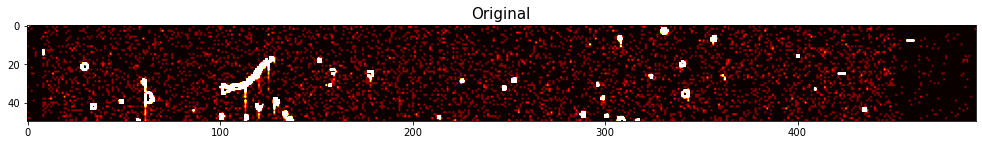

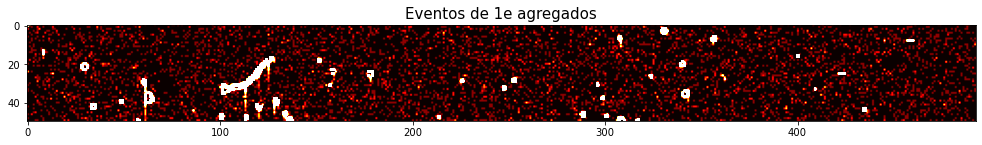

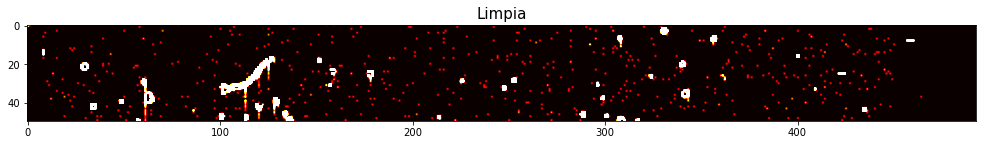

In [40]:
from scipy.stats import poisson
# =============================================================================
# elijo una imagen random del montón
rnd_image = np.random.choice(fits_imgs_list)

# Creo el objeto fits_image
fits_image = ManipulateFits()

# Me quedo con la imagen de 2 o más eventos
clean_image = fits_image.single_fits2double_fits(rnd_image)[1]


# =============================================================================
# ploteo la imagen original
ori_image = fits_image.ADU2e(rnd_image)

plt.figure(figsize=(17, 2))
plt.imshow(ori_image, cmap="hot", vmin=0, vmax=5)
plt.title("Original", fontsize=15);

# =============================================================================
# ploteo la imagen con el ruido agregado (tengo que buclear de nuevo)
noisy_image = clean_image.copy()

# Agrego el ruido con distribución de Poisson
noisy_image += poisson.rvs(mu = 0.2245, size=(50,493))


# con un bucle for, agrego el ruido si un random es menor que prob
#$for ix, iy in np.ndindex(clean_image.shape):
    # si un numero random es menor que prob, entonces sumo un e-
#    if np.random.rand() < prob:
#        noisy_image[ix,iy] += 1

#mask = np.random.rand(50,493)
#noisy_image = np.where(mask < prob, 
#                       noisy_image +1,
#                       noisy_image)

plt.figure(figsize=(17, 2))
plt.imshow(noisy_image, cmap="hot", vmin=0, vmax=5)
plt.title("Eventos de 1e agregados", fontsize=15);

# =============================================================================
# ploteo la imagen limpia
plt.figure(figsize=(17, 2))
plt.imshow(clean_image, cmap="hot", vmin=0, vmax=5)
plt.title("Limpia", fontsize=15);

Y lo que se ve hasta el momento tiene sentido, la imagen original y la que tiene los eventos agregados son similares.

Pero lo quiero hacer para todas las imagenes, y no puedo graficarlas, tengo que ver los datos unicamente.

Tomo todas las imágenes y nuevamente me armo una lista de diccionarios con sus features, antes de agregarle los eventos de un electrón. 

Voy a mirar las imágenes completas, pero aplicando un detection threshold de 2 electrones.

Me guardo en una lista los labels de cada imagen. Los labels son un array de numpy de la dimensión de la imagen, asi que voy a tener una lista de arrays de numpy de la forma $NxM = 50 \times 493$. Cada label es una matriz llena de 0's donde no hay clusters y luego números aglomerados para indicar los clusters identificados, es decir, aglomeraciones de 1's, de 2's, de 3's.... etc.

### Busco los clusters de las imagenes originales:

In [41]:
# =============================================================================
# Listas para almacenar la info
lista_dics = []
lista_labels = []
lista_n_features = []

# bucle for para agregar los eventos de 1e-
for i, image in enumerate(fits_imgs_list):
    # cargo la imagen
    cluster_img = ManipulateFits().ADU2e(image)
    # Binarizo la imagen
    image_e_bw = misc.img2bw(cluster_img, low_th=2, upp_th=300)
    # Genero las labels y también guardo el número de features
    label_im, n_features = ndi.label(image_e_bw,
                                     structure=[[0, 1, 0],
                                                [1, 1, 1],
                                                [0, 1, 0]])

    # Me armo el diccionario con toda la información
    dic = datafits.get_cluster_info(cluster_img, label_im)
    # Guardo en listas el dic, los labes y el numero de features
    # o clusters detectados
    lista_dics.append(dic)
    lista_labels.append(label_im)
    lista_n_features.append(n_features)
    # printea el progreso de la iteración
    print("\r%.2f%%" % (100*i/924), end = "")

103.14%

Ya tengo todos los features y todos los labels guardados en variables. El feature que me interesa es la "energia" de cada cluster, que en realidad son la cantidad de electrones por cluster.

El siguiente paso sería tomar las imágenes sin eventos de 1 electrón, agregárselos sintéticamente y luego repetir el proceso y comparar "la energía" de los clústers.

Tomo todas las imágenes y les agrego ruido: para eso lo que hago es
- Abro la primera imagen y me quedo con la de los eventos de 2 o más electrones
- Usando un generador de numeros random con distribución de Poisson y $\mu = 0.2245$, armo una matriz de ruido que se la agrego a la imagen limpia
- Con los labels que ya tengo, busco la info de los clusters. OBSERVACION: Acá aparecen dos posibilidades.
    - Usar los labels de antes para comparar exactamente las mismas regiones
    - Buscar nuevos labels, dado que con los nuevos eventos de 1e las regiones no van a ser estrictamente las mismas. Este caso lo analizaré después.


### Tomo las imágenes de 2 o más electrones y les agrego ruido

In [42]:
# =============================================================================
# lista para almacenar la info
# prob es una variable que tengo definida al final de la primera parte
lista_dics_noisy = []
# bucle for para abrir la imagen y agregarle el ruido
for i, image in enumerate(fits_imgs_list):
    # abro la imagen, cargo la que tiene 2 o más eventos por pixel
    fits_image = ManipulateFits()
    cluster_img_noise = fits_image.single_fits2double_fits(image)[1]
    # Agrego ruido poissoniano a la imagen
    cluster_img_noise += poisson.rvs(mu = 0.2245, size=(50,493))
    # acá ya tengo la imagen con los eventos de 1e agregados. Ahora me armo
    # el diccionario de features usando la función get_cluster_info y los
    # labels que ya tenía de antes en una lista
    dic_noisy = datafits.get_cluster_info(cluster_img_noise, lista_labels[i])
    lista_dics_noisy.append(dic_noisy)
    print("\r%.2f%%" % ((i+1)*100/len(fits_imgs_list)), end="")

100.00%

Ahora voy a usar la lista de diccionarios que hice antes, ```datos_dic```. La idea es armarme un DataFrame de pandas (una tabla) para tener lado a lado la info y poder compararla de una forma más comoda, si se quiere, de la siguiente manera


cluster | areas | conteo original | conteo simulado | diff | diff/area
:---:|:---:|:---:|:---:|:---:|:---:
1 | 1 | 5 | 5 | 0 | 0
2 | 10 | 50 | 52 | 2 | 0.2
3 | 1 | 6 | 6 | 0 | 0
4 | 3 | 35 | 37 | 2 | 0.6
. | . | . | . | . |
. | . | . | . | . |
. | . | . | . | . |

In [43]:
# =============================================================================
import pandas as pd
# armo listas para meter los datos
areas = []
perimetros = []
energia_original = []
energia_simulada = []

# meto los datos en las listas
for dics_o, dics_n in zip(lista_dics, lista_dics_noisy):
    areas.append(dics_o["areas"])
    perimetros.append(dics_o["perimetro"])
    energia_original.append(dics_o["energias"])
    energia_simulada.append(dics_n["energias"])

# concateno todos los datos en un array de numpy 
# (si no hago este paso quedan listas de listas)
areas = np.concatenate(areas)
perimetros = np.concatenate(perimetros)
energia_original = np.concatenate(energia_original)
energia_simulada = np.concatenate(energia_simulada)

# me armo un array auxiliar para los índices del DataFrame
idxs = np.arange(1, len(areas)+1, 1)

# Me armo un diccionario que voy a transformar al DataFrame
diccionario = {"cluster": idxs,
               "areas": areas,
               "perimetros": perimetros,
               "conteo_original": energia_original,
               "conteo_simulado": energia_simulada}

# Genero el DataFrame
df = pd.DataFrame.from_dict(diccionario)
df.set_index("cluster", inplace=True)
df.sort_values("areas", inplace=True)
df["diff"] = df["conteo_simulado"] - df["conteo_original"]
df["diff/area"] = df["diff"]/df["areas"]
df[["conteo_original", "conteo_simulado", "diff"]] = df[["conteo_original",
                                                         "conteo_simulado",
                                                         "diff"]].astype("int")
df

,areas,perimetros,conteo_original,conteo_simulado,diff,diff/area
cluster,,,,,,
283113,1,0.000000,5,6,1,1.000000
361860,1,0.000000,263,263,0,0.000000
361859,1,0.000000,2,2,0,0.000000
361858,1,0.000000,2,2,0,0.000000
361857,1,0.000000,2,3,1,1.000000
...,...,...,...,...,...,...
26363,138,134.006097,1465,1496,31,0.224638
93494,163,160.798990,2266,2298,32,0.196319
472,177,176.207107,1105,1157,52,0.293785


Y acá ya tengo la información ordenada, cómoda y muy fácilmente manipulable

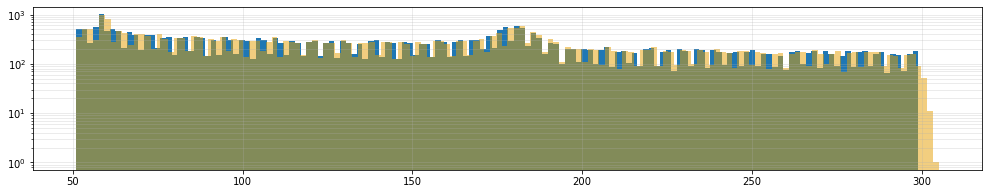

In [44]:
# me armo un DF auxiliar que después borro
DF = df[(df["conteo_original"]<300) & (df["conteo_original"]>50)]
conteo_ori_50a300 = DF["conteo_original"].values
conteo_sim_50a300 = DF["conteo_simulado"].values
plt.figure(figsize=(17, 3))
plt.hist(conteo_ori_50a300,
         bins=150)
plt.hist(conteo_sim_50a300,
         bins=150,
         color="#E69F00",
         alpha=.5)
plt.yscale("log")
plt.grid(which="both", alpha=.3)
# borro el DF auxiliar
del DF

Ya tengo los datos que necesito, ya podría comparar. Voy a hacer dos histogramas para ver rápidamente como se ve todo. Uno con matplotlib y otro con seaborn porque por qué no

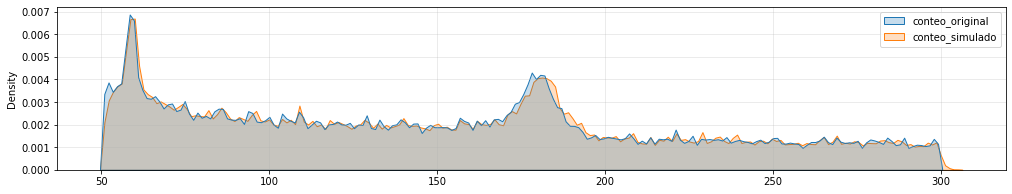

In [45]:
import seaborn as sns
DF = df[["conteo_original", "conteo_simulado"]]
DF = DF[(DF["conteo_original"]<300) & (DF["conteo_original"]>50)]
fig, ax = plt.subplots(1, figsize=(17, 3))
sns.kdeplot(ax=ax, data=DF, bw_adjust=.05, fill=True)
#plt.yscale("log")
plt.grid(which="both", alpha=.3)
del DF

Ahora tengo lograr encontrar los clústeres que son diferentes a los originales, o sea, los que ahora tienen algún electrón más arriba. Voy a comparar cluster a cluster cuál cambio. Voy a anotar los siguientes datos:
- Cuántos clusters se modificaron y cuántos no
- Mirando los clusters modificados, cuántos electrones de diferencia hay.


La primera me da la probabilidad de global de que a un clúster le caiga al menos un electrón espurio.

#### Clústers modificados y sin modificar

In [46]:
# Número total de clústers (de todas las imágenes)
N_clusters = len(df["conteo_original"].values)

# Cuántos clusters NO se modificaron:
# La suma considera 1 a los True, asi que va a sumar todos los True
N_clusters_intactos = sum(df["conteo_original"]==df["conteo_simulado"])

# Cuántos clusters SI se modificaron
N_clusters_modificados = N_clusters - N_clusters_intactos
print("Clústers modificados: %i, son el %.2f%%" % 
      (N_clusters_modificados, N_clusters_modificados*100/N_clusters))
print("Clústers sin modificar: %i, son el %.2f%%" %
      (N_clusters_intactos, N_clusters_intactos*100/N_clusters))

Clústers modificados: 139290, son el 24.60%
Clústers sin modificar: 426935, son el 75.40%


#### La probabilidad de que a un cluster le caiga al menos un electrón espurio anda por el 40% cuando miro con un threshold simple (eventos > 2). Cuando miro un threshold doble (eventos >2 y < 300) cae a 30%


Notar que estos son todos los clusters que el programa reconoce por encima del detection threshold, que en este caso es 2! No estoy discriminando de los que andan cerca de 180 electrones, correspondientes al $X$ del Flúor

### Hasta acá llego con lo de montecarlo.

# Métodos analíticos

## Binomial

Supongo que la variable aleatoria "número de electrones espúrios por clúster" tiene una distribución binomial. 

La esperanza de la binomial es $NP$, donde $N$ va a ser el número de píxeles que tiene el clúster y $P$ la probabilidad por píxel de que haya un electrón espurio.

Grafico la esperanza (valor medio del número de electrones espúrios por clúster) en función de las áreas de los clústers. 

Y también vuelvo a graficar lo medido, la diferencia de conteo de electrones por clusters en función de las áreas, para comprar

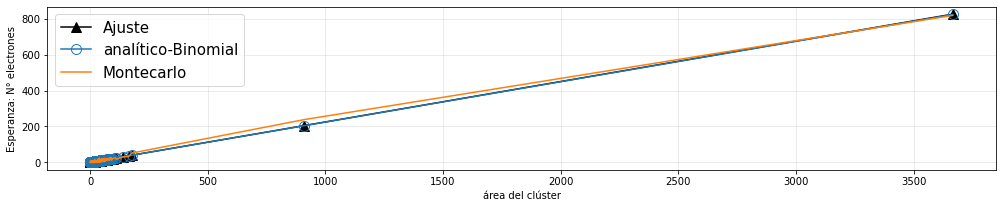

In [47]:
probabilidad = 0.2245
# le agrego una columna "esperanza_binomial" al DataFrame
# prob es una variable definida al final de la primera parte
df["esperanza_binomial"] = df["areas"]*probabilidad
plt.figure(figsize=(17,3))
# ploteo el ajuste lineal
m, b = misc.regresion_lineal(df["areas"], df["diff"])
plt.plot(df["areas"], m*df["areas"]+b,
         "k^-",
         markersize=10,
         label="Ajuste")
# ploteo el analítico
plt.plot(df["areas"].values, df["esperanza_binomial"].values,
         'o-',
         markersize=10,
         fillstyle="none",
         label="analítico-Binomial")
# ploteo el Montecarlo
plt.plot(df["areas"].values, df["diff"],
         label="Montecarlo")
plt.grid(alpha=.3)
plt.ylabel("Esperanza: N° electrones")
plt.xlabel("área del clúster")
plt.legend(fontsize=15);
#plt.axis([-1,50, -5 ,15])

Voy a promediar las diferencias de electrones por cluster, en base a las áreas. Es decir, si tengo varios clusters de igual área, es claro que voy a tener distintas diferencias de electrones en cada uno. Entonces hago el promedio de la cantidad de electrones para clusters de área 1, 2, 3, ..., N.

Eso se hace fácil con pandas usando el método ```groupby``` del dataframe de la siguiente manera:
- Me armo un nuevo DataFrame, que va a estar reducido en tamaño y va a tener como índice a las áreas,
- Transformo a la áreas en columnas (```reset_index()```),
- Ploteo, pero no más allá de los clusters de tamaño mayor a 50 píxeles (uso el método ```head(50)```)

También hago un nuevo ajuste usando cuadrados mínimos.


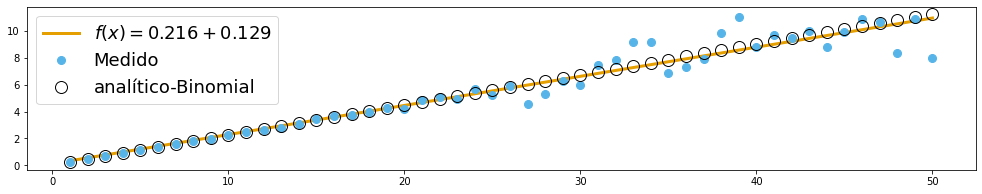

In [48]:
# =============================================================================
# nuevo DataFrame
DF = df[["areas", "diff", "esperanza_binomial"]].groupby("areas").mean()
DF["error"] = df[["areas", "diff"]].groupby("areas").std()
# reseteo el índice 
DF.reset_index(inplace=True)

# Hago el ajuste
m, b = misc.regresion_lineal(DF["areas"].head(50), DF["diff"].head(50))


plt.figure(figsize=(17, 3))
# ploteo el ajuste
plt.plot(DF["areas"].head(50), DF["areas"].head(50)*m + b, 
         color="#E69F00",
         linewidth=3,label="$f(x)=%.3f + %.3f$" % (m, b))

# ploteo los datos promediados
plt.plot(DF["areas"].head(50), DF["diff"].head(50),
         'o',
         color="#56B4E9", 
         markersize=8,
         label="Medido")

# ploteo la teórica (binomial) con circulos abiertos
plt.plot(DF["areas"].head(50), DF["esperanza_binomial"].head(50),
         'o',
         color="k",
         markersize=12,
         fillstyle="none",
         label="analítico-Binomial")
plt.legend(fontsize=18);
#plt.savefig("BinomialVSMontecarlo.pdf")

Da todo muy parecido, a pesar de que el analítico no considera la posibilidad de que caiga más de un electrón sobre el mismo píxel de un clúster!


## Poissoniana

La variable aleatoria "Número de electrones espurios que hay en un cluster" tiene distribución de Poisson. La probabilidad $P$ de que en un dado píxel caiga 1 electrón espurio ($k = 1$) se escribe como

$$p = P(\mu | k = 1) \equiv P = 0.1834$$

por el rate que calculé antes, al analizar las imágenes. Pero como sé que la variable aleatoria es Poissoniana, puedo, a partir de este valor inferir el $\mu$ de la Poissoniana despejándolo numéricamente, es decir, busco el valor de $\mu$ tal que $p(\mu | k = 1) = 0.1834$

Hecho artesanalmente sería:

In [49]:
prob_corr_global, poisson.pmf(k=1, mu=0.23118292), poisson.pmf(k=1, mu=prob_corr_global),

(0.18783253, 0.1834654449085466, 0.15566686710481983)

Entonces el $\mu \approx 0.2320$

Por otro lado, la Poissoniana se escribe com

$$P(\mu|k) = \frac{\mu^{k} e^{-\mu}}{k!}$$

Entonces $P(\mu|k=1) = \mu e^{-\mu}$ y $P(\mu|k=0) = e^{-\mu}$

Como antes lo que hice fue dividir el número de píxeles con 1 electrón por el número de píxeles con 0 y con 1 electrón, eso es equivalente a hacer

$$\frac{P(\mu|k=1)}{P(\mu|k=0) + P(\mu|k=1)} 
    = \frac{\mu e^{-\mu}}{e^{-\mu} + \mu e^{-\mu}}
    = \frac{\mu}{\mu + 1}
    \equiv R$$

donde $R$ es el rate que calculé antes, es decir, $R \approx 0.1834$. Despejando $\mu$ se llega a

$$ \mu = \frac{R}{1-R} \approx 0.2245$$

Bastante parecido al despejado numéricamente, habría que ver el error de eso para ver si realmente son "parecidos" o si es coincidencia. El problema, nuevamente, es que no calculé una incerteza para la probabilidad al usar el segundo metodo (que saca el sesgo de los píxeles ocupados por 2 o más electrones)

#### Lo que necesito saber para corregir la estadística de las mediciones es *la esperanza de la variable aleatoria: Número de electrones espurios por clúster*. Cómo los clusters tienen tamaño $N$, donde $N$ es la cantidad de píxeles, necesito saber la esperanza en función del $N$. 

Si por ejemplo tengo un clúster de 1 solo píxel, entonces la probabilidad de tener $1$, $2$, $3$ o $N$ electrones en ese píxel la puedo escribir con la Poissoniana $P(k=1,\mu=0.20)$, $P(k=2, \mu=0.20)$, ..., $P(k=N, \mu=0.20)$ etc.

Si $k$, variable aleatoria con distribución Poissoniana, es el número de electrones espurios por píxel, la esperanza de la variable aleatoria $k$ viene dada por $E(k) = \mu$. Pero para un clúster de $N$ píxeles, el número de electrones espurios por clúster será

$$ n = \sum\limits_{i=1}^{N}k_{i}$$

donde $k_{i}$ es la cantidad de electrones espurios en el píxel $i$-ésimo. Entonces, quiero calcular la esperanza de $n$, $E(n)$, y como la esperanza de la suma es la suma de las esperanzas, se tiene

$$E(n) = E\left( \sum\limits_{i=1}^{N} k_{i}\right) = \sum\limits_{i=1}^{N}E(k_{i})$$

como la esperanza de la distribución es la misma, para cualquier $k_{i}$ es el mismo $\mu$, entonces

$$E(n) = \mu \sum\limits_{i=1}^{N} 1 = N \mu,$$

Entonces, la esperanza de la variable aleatoria **número de electrones espurios en un cluster** viene dada por $N\mu$, muy parecida a la binomial.

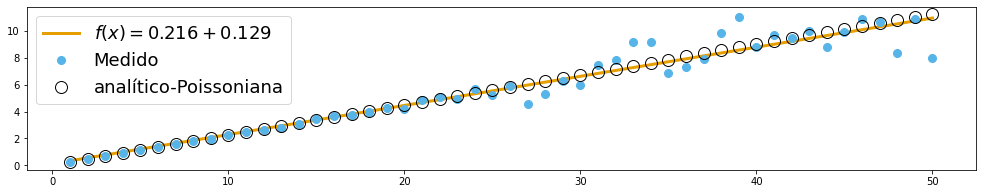

In [50]:
DF["esperanza_poisson"] = DF["areas"]*probabilidad
plt.figure(figsize=(17, 3))
# ploteo el ajuste
plt.plot(DF["areas"].head(50), DF["areas"].head(50)*m + b, 
         color="#E69F00",
         linewidth=3,label="$f(x)=%.3f + %.3f$" % (m, b))

# ploteo los datos promediados
plt.plot(DF["areas"].head(50), DF["diff"].head(50),
         'o',
         color="#56B4E9", 
         markersize=8,
         label="Medido")

# ploteo la teórica (Poisson) con circulos abiertos
plt.plot(DF["areas"].head(50), DF["esperanza_poisson"].head(50),
         'o',
         color="k",
         markersize=12,
         fillstyle="none",
         label="analítico-Poissoniana")
plt.legend(fontsize=18);
#plt.savefig("PoissonVSMontecarlo.pdf")

### A realizar
- Analizar el caso en el que se buscan los features de 0 en las imágenes con ruido simulado.
- Filtrar todos los datos que no sean de eventos entre 160 y 200 electrones.
- Calcular incertezas de los datos.
- Distribución de tamaños de los clústers.
- Búsqueda de clusters coincidentes al agregar eventos de 1e.


## Busco features en imágenes originales:

In [51]:
import pandas as pd
# =============================================================================
# Listas para almacenar la info
lista_dics = []
lista_labels = []
lista_n_features = []
lista_idxs = []

# bucle for para agregar los eventos de 1e-
for i, image in enumerate(fits_imgs_list):
    # cargo la imagen
    cluster_img = ManipulateFits().ADU2e(image)
    # Binarizo la imagen
    image_e_bw = misc.img2bw(cluster_img, low_th=2, upp_th=300)
    # Genero las labels y también guardo el número de features
    label_im, n_features = ndi.label(image_e_bw,
                                     structure=[[0, 1, 0],
                                                [1, 1, 1],
                                                [0, 1, 0]])

    # Me armo el diccionario con toda la información
    dic = datafits.get_cluster_info(cluster_img, label_im)
    # Guardo en listas el dic, los labes y el numero de features
    # o clusters detectados y además un index para matchear features
    # con la imagen a la que pertenece
    lista_dics.append(dic)
    lista_labels.append(label_im)
    lista_n_features.append(n_features)
    lista_idxs.append(np.ones(n_features)*i)
    # printea el progreso de la iteración
    print("\r%.2f%%" % (100*i/924), end = "")

103.14%

## Tomo imágenes sin ruido, les agrego el ruido sintético, les busco sus labels y extraigo los nuevos features. A su vez, miro los features originales usando los labels originales.

In [52]:
# =============================================================================
# Uso la prob que ya tengo

# Listas para almacenar la info
lista_dics_noisy = []
lista_labels_noisy = []
lista_n_features_noisy = []
lista_idxs_noisy = []
# lista de las features extraidas a partir de los labels de los datos originales
lista_dic_label_o = []

# bucle for para aabrir laiamgen y agregarle el ruido
for i, image in enumerate(fits_imgs_list):
    # abro la imagen con eventos de 2 o más electrones
    fits_image = ManipulateFits()
    cluster_img_noisy = fits_image.single_fits2double_fits(image)[1]
    
    # Agrego ruido Poissoniano
    cluster_img_noisy += poisson.rvs(mu = 0.2245, size=(50,493))

    # Binarizo la imagen con ruido sintético
    image_e_bw = misc.img2bw(cluster_img_noisy, low_th=2, upp_th=300)
    
    # Genero los labels y también guardo el número de features
    label_im, n_features = ndi.label(image_e_bw,
                                     structure=[[0, 1, 0],
                                                [1, 1, 1],
                                                [0, 1, 0]])

    # Extraigo la info de las imágenes simuladas con labels originales
    dic_label_o = datafits.get_cluster_info(cluster_img_noisy, lista_labels[i])
    
    # Extraigo la info de las imágenes simuladas con labels nuevos
    dic_noisy = datafits.get_cluster_info(cluster_img_noisy, label_im)

    # Armo listas
    lista_dics_noisy.append(dic_noisy)
    lista_labels_noisy.append(label_im)
    lista_n_features_noisy.append(n_features)
    lista_idxs_noisy.append(np.ones(n_features)*i)
    lista_dic_label_o.append(dic_label_o)
    print("\r%.2f%%" % ((i+1)*100/len(fits_imgs_list)), end="")


100.00%

##### En esta celda que sigue veo visualmente los clústers simulados y los originales a ver qué es lo que el código está detectando

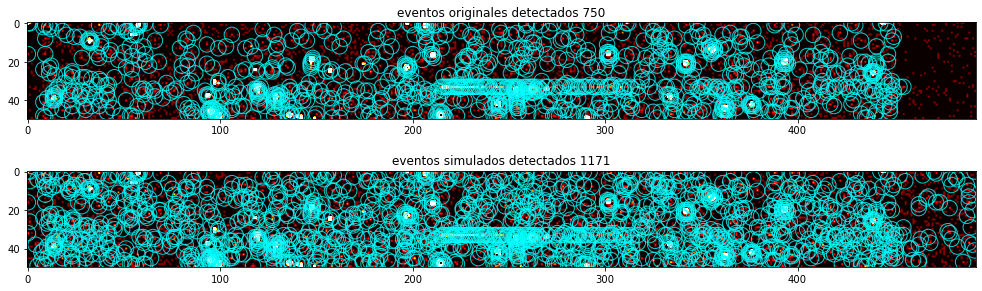

In [53]:
# ===========================================================================
img_path = np.random.choice(fits_imgs_list)

fits_image = ManipulateFits()
image = fits_image.ADU2e(img_path)

image_clean = fits_image.single_fits2double_fits(img_path)[1]

#mask = np.random.rand(50,493)


#image_sim = np.where(mask < prob,
#                    image_clean + 1,
#                    image_clean)

image_sim = poisson.rvs(mu=0.2245, size=(50,493)) + image_clean

image_bw_o = misc.img2bw(image, low_th=2, upp_th=300)

image_bw_sim = misc.img2bw(image_sim, low_th=2, upp_th=300)

label_o, n_features_o = ndi.label(image_bw_o, 
                                  structure=[[0, 1, 0],
                                             [1, 1, 1],
                                             [0, 1, 0]])
label_sim, n_features_sim = ndi.label(image_bw_sim, 
                                  structure=[[0, 1, 0],
                                             [1, 1, 1],
                                             [0, 1, 0]])


# Armo el diccionario con la información que me devuelve get_cluster_size_etc
dic_o = datafits.get_cluster_info(image, label_o)

dic_sim = datafits.get_cluster_info(image_sim, label_sim)

# Me genero el layout del plot
fig, axs = plt.subplots(2,1, figsize=(17,5))

coords_o = dic_o["coordenadas"]
coords_sim = dic_sim["coordenadas"]
for coords in coords_o:
    for r in coords:
        r = list(r)
        r.reverse()
        circ_o = Circle(tuple(r), 4, alpha=.8, color="cyan", fill=False)
        axs[0].add_patch(circ_o)
        
for coords in coords_sim:
    for r in coords:
        r = list(r)
        r.reverse()
        circ_sim = Circle(tuple(r), 4, alpha=.8, color="cyan", fill=False)
        axs[1].add_patch(circ_sim)
# Ploteo la imagen
axs[0].set_title("eventos originales detectados %i" %n_features_o)
axs[0].imshow(image, cmap="hot", vmin=0, vmax=5);
axs[1].set_title("eventos simulados detectados %i" %n_features_sim)
axs[1].imshow(image_sim, cmap="hot", vmin=0, vmax=5);

#plt.savefig("/home/igna/Escritorio/imagen_asds.pdf")

In [54]:
prob_0 = np.exp(-prob)
prob_1 = prob*np.exp(-prob)
prob_2 = 1 - prob_0 - prob_1
prob_0, prob_1, prob_2

(0.8287535, 0.15566686, 0.015579670667648315)

## Arreglo la info en un DataFrame

In [55]:
# armo listas para meter los datos
# originales
area_original = []
centro_original = []
perimetro_original = []
energia_original = []

# simuladas
area_sim = []
centro_sim = []
perimetro_sim = []
energia_sim = []
idx_sim = []

# simuladas y labels originales
area_sim_label_o = []
centro_sim_label_o = []
perimetro_sim_label_o = []
energia_sim_label_o = []

# meto los datos en las listas
for dics_o, dics_n, dics_l in zip(lista_dics, lista_dics_noisy, lista_dic_label_o):
    # originales
    area_original.append(dics_o["areas"])
    centro_original.append(dics_o["centros"])
    perimetro_original.append(dics_o["perimetro"])
    energia_original.append(dics_o["energias"])
    # simulados
    area_sim.append(dics_n["areas"])
    centro_sim.append(dics_n["centros"])
    perimetro_sim.append(dics_n["perimetro"])
    energia_sim.append(dics_n["energias"])
    # 
    area_sim_label_o.append(dics_l["areas"])
    centro_sim_label_o.append(dics_l["centros"])
    perimetro_sim_label_o.append(dics_l["perimetro"])
    energia_sim_label_o.append(dics_l["energias"])
    
# concateno todos los datos en un array de numpy 
# (si no hago este paso quedan listas de listas)
# originales
area_original = np.concatenate(area_original)
centro_original = np.concatenate(centro_original)
perimetro_original = np.concatenate(perimetro_original)
energia_original = np.concatenate(energia_original)
idx_original = np.concatenate(lista_idxs)
# simulados
area_sim = np.concatenate(area_sim)
centro_sim = np.concatenate(centro_sim)
perimetro_sim = np.concatenate(perimetro_sim)
energia_sim = np.concatenate(energia_sim)
idx_sim = np.concatenate(lista_idxs_noisy)
# simulados pero con labels originales
area_sim_label_o = np.concatenate(area_sim_label_o)
centro_sim_label_o = np.concatenate(centro_sim_label_o)
perimetro_sim_label_o = np.concatenate(perimetro_sim_label_o)
energia_sim_label_o = np.concatenate(energia_sim_label_o)

In [56]:
# Me armo un diccionario que voy a transformar al DataFrame
diccionario = {"idx_img": idx_original,
               "area_original": area_original,
               "conteo_original": energia_original,
               "centro_original": centro_original,
               "perimetro_original": perimetro_original,
               "area_sim_label_o": area_sim_label_o,
               "conteo_sim_label_o": energia_sim_label_o,
               "centro_sim_label_o": centro_sim_label_o,
               "perimetro_sim_label_o": perimetro_sim_label_o,
               "idx_img_sim": idx_sim,
               "area_sim": area_sim,
               "conteo_sim": energia_sim,
               "centro_sim": centro_sim,
               "perimetro_sim": perimetro_sim}

In [57]:
# Genero el DataFrame
df = pd.DataFrame.from_dict(diccionario, orient="index")
df = df.transpose()
#df.set_index("cluster", inplace=True)
#df.sort_values("area_original", inplace=True)
df["diff"] = abs(df["conteo_sim"] - df["conteo_original"])
df["diff_l"] = abs(df["conteo_original"] - df["conteo_sim_label_o"])
df["diff/area_o"] = df["diff"]/df["area_original"]
df["diff/area_s"] = df["diff"]/df["area_sim"]
df["p_diff"] = abs(df["perimetro_sim"] - df["perimetro_original"])
#df[["conteo_original", "conteo_simulado", "e_diff"]] = df[["conteo_original",
#                                                         "conteo_simulado",
#                                                         "e_diff"]].astype("int")
#df.sort_values("area_original", inplace=True)

In [58]:
df

,idx_img,area_original,conteo_original,centro_original,perimetro_original,area_sim_label_o,conteo_sim_label_o,centro_sim_label_o,perimetro_sim_label_o,idx_img_sim,area_sim,conteo_sim,centro_sim,perimetro_sim,diff,diff_l,diff/area_o,diff/area_s,p_diff
0,0,2,57,"[0.0, 0.5]",0,2,57,"[0.0, 0.5]",0,0,2,57,"[0.0, 0.5]",0,0,0,0,0,0
1,0,2,164,"[0.0, 328.5]",0,2,164,"[0.0, 328.5]",0,0,1,2,"[0.0, 48.0]",0,162,0,81,162,0
2,0,5,465,"[0.6, 378.4]",3,5,465,"[0.6, 378.4]",3,0,1,2,"[0.0, 265.0]",0,463,0,92.6,463,3
3,0,1,2,"[1.0, 110.0]",0,1,2,"[1.0, 110.0]",0,0,1,2,"[0.0, 301.0]",0,0,0,0,0,0
4,0,1,2,"[1.0, 112.0]",0,1,2,"[1.0, 112.0]",0,0,2,164,"[0.0, 328.5]",0,162,0,162,81,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983161,None,None,None,None,None,None,None,None,None,953,1,2,"[49.0, 344.0]",0,NaN,NaN,NaN,NaN,NaN
983162,None,None,None,None,None,None,None,None,None,953,1,2,"[49.0, 356.0]",0,NaN,NaN,NaN,NaN,NaN
983163,None,None,None,None,None,None,None,None,None,953,1,2,"[49.0, 399.0]",0,NaN,NaN,NaN,NaN,NaN
983164,None,None,None,None,None,None,None,None,None,953,1,2,"[49.0, 451.0]",0,NaN,NaN,NaN,NaN,NaN


In [59]:
df[(df["conteo_sim"]<200) & (df["conteo_sim"]>160)].shape

(6954, 19)

In [60]:
df[(df["conteo_original"]<200) & (df["conteo_original"]>160)].shape

(6940, 19)

## Descripción de DataFrame
Tiene básicamente 3 tipos de columnas:
- ***_original**: Datos extraídos de las imágenes originales
- ***_sim_label_o**: Datos extraídos de las imágenes con ruido simulado, pero usando los clústeres detectados de las imágenes originales
- ***_sim**: Datos extraídos de las imágenes con ruido simulado.

Además, el DataFrame tiene información de:
- Áreas
- Coordenadas del centro del clúster
- Perímetro de los clústers
- Conteo de electrones de los clústers
- diff: Diferencia de conteo entre clusters originales y simulados
- diff_l: Diferencia de conteo entre clusters originales y simulados (con labels de originales)

In [61]:
df.head(3)

,idx_img,area_original,conteo_original,centro_original,perimetro_original,area_sim_label_o,conteo_sim_label_o,centro_sim_label_o,perimetro_sim_label_o,idx_img_sim,area_sim,conteo_sim,centro_sim,perimetro_sim,diff,diff_l,diff/area_o,diff/area_s,p_diff
0,0,2,57,"[0.0, 0.5]",0,2,57,"[0.0, 0.5]",0,0,2,57,"[0.0, 0.5]",0,0,0,0,0,0
1,0,2,164,"[0.0, 328.5]",0,2,164,"[0.0, 328.5]",0,0,1,2,"[0.0, 48.0]",0,162,0,81,162,0
2,0,5,465,"[0.6, 378.4]",3,5,465,"[0.6, 378.4]",3,0,1,2,"[0.0, 265.0]",0,463,0,92.6,463,3


### 1) Filtro toda la info de clusters (originales) que no tengan entre 160 y 200 electrones

In [62]:
# me quedo solo con los clusters originales entre 200 y 160 electrones
df_clean = df[(df["conteo_original"]<200) & (df["conteo_original"]>160)]
df_clean2 = df[(df["conteo_sim_label_o"]<200) & (df["conteo_sim_label_o"]>160)]

Con esos datos filtrados, miro cuál es la probabilidad de que a esos clústers les caiga algún electrón. Entonces básicamente miro cuántos de esos clústers se modificaron y cuántos no.

#### Clústeres originales vs simulados con mismos labels

In [63]:
# Número total de clústers (de todas las imágenes)
N_clusters = len(df_clean["conteo_original"].values)

# Cuántos clusters NO se modificaron:
# La suma considera 1 a los True, asi que va a sumar todos los True
N_clusters_intactos = sum(df_clean["conteo_original"]==df_clean["conteo_sim_label_o"])

# Cuántos clusters SI se modificaron
N_clusters_modificados = N_clusters - N_clusters_intactos
print("Clústers modificados: %i, son el %.2f%%" % 
      (N_clusters_modificados, N_clusters_modificados*100/N_clusters))
print("Clústers sin modificar: %i, son el %.2f%%" %
      (N_clusters_intactos, N_clusters_intactos*100/N_clusters))

Clústers modificados: 4011, son el 57.80%
Clústers sin modificar: 2929, son el 42.20%


#### Clústers originales vs simulados con nuevos labels

In [64]:
# Número total de clústers (de todas las imágenes)
N_clusters = len(df_clean["conteo_original"].values)

# Cuántos clusters NO se modificaron:
# La suma considera 1 a los True, asi que va a sumar todos los True
N_clusters_intactos = sum(df_clean["conteo_original"]==df_clean["conteo_sim"])

# Cuántos clusters SI se modificaron
N_clusters_modificados = N_clusters - N_clusters_intactos
print("Clústers modificados: %i, son el %.2f%%" % 
      (N_clusters_modificados, N_clusters_modificados*100/N_clusters))
print("Clústers sin modificar: %i, son el %.2f%%" %
      (N_clusters_intactos, N_clusters_intactos*100/N_clusters))

Clústers modificados: 6939, son el 99.99%
Clústers sin modificar: 1, son el 0.01%


#### Los clústers simulados con nuevos labels son todos distintos y no puedo matchearlos todavía

## 3) Distribución de tamaños

In [65]:
plt.figure(figsize=(17, 4)) corrientes oscuras u otros factores
plt.hist(df_clean["area_original"], bins=50)
plt.title("distribución de tamaños de clusters de imágenes originales")
plt.savefig("Dist_tamaños_cluster_180e.pdf")
plt.figure(figsize=(17, 4))
plt.hist(df_clean["area_sim_label_o"], bins=50);
plt.figure(figsize=(17, 4))
plt.hist(df_clean["area_sim"], bins=50);

SyntaxError: invalid syntax (<ipython-input-65-4dd4d82f1907>, line 1)